In [1]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np

In [2]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
%matplotlib inline
swift = SWIFT(root_path=r'data', res=64, n_bands=[1,2,3,4,5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


In [4]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_Noise_Reduced_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
grb_names, features = data_loaded['names'], data_loaded['data']
durations = swift.total_durations(grb_names, t=90)

Finding Durations: 100%|██████████████████| 1513/1513 [00:08<00:00, 188.78GRB/s]


In [5]:
features.shape

(1513, 48000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


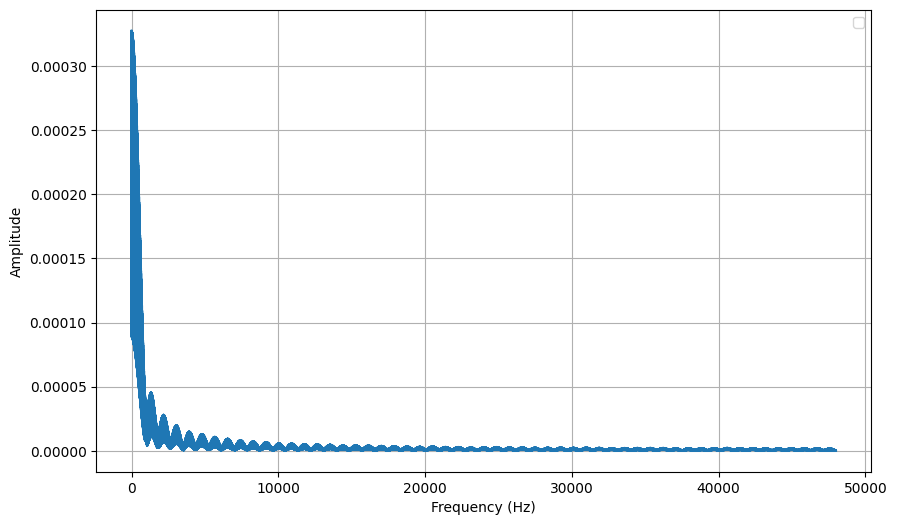

In [6]:
x = np.linspace(0, features.shape[1], features.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(x, features[0])  # Converting tensor to numpy array for plotting
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.legend()
plt.grid(True)

In [7]:
features = features[:,:8000]
features.shape

(1513, 8000)

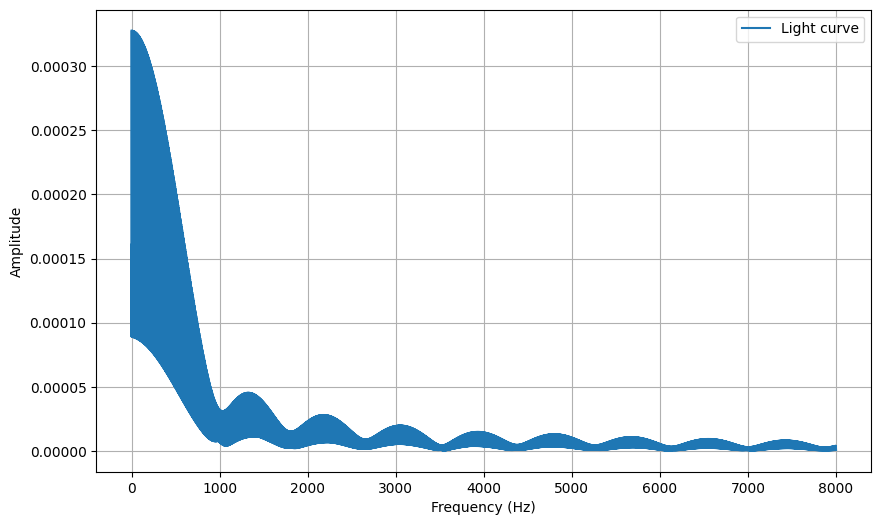

In [8]:
x = np.linspace(0, features.shape[1], features.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(x, features[0], label='Light curve')  # Converting tensor to numpy array for plotting
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

In [9]:
# Normalize the features here
normalized_features = (features - np.mean(features, axis=1, keepdims=1))/np.std(features,axis=1,keepdims=1)
print(normalized_features.shape)
print(np.mean(normalized_features,axis=1))
print(np.std(normalized_features,axis=1))

(1513, 8000)
[1.13686838e-16 2.84217094e-17 5.68434189e-17 ... 0.00000000e+00
 0.00000000e+00 5.68434189e-17]
[1. 1. 1. ... 1. 1. 1.]


In [10]:
_normalized_features = normalized_features # copy this so rerunning next cell doesn't throw error
_labels = np.zeros(shape=(normalized_features.shape[0],1))

In [11]:
normalized_features = torch.from_numpy(_normalized_features).to(torch.float32)
labels = torch.from_numpy(_labels).to(torch.float32)

In [12]:

# Split the cleaned data into training and testing sets
X_train, X_test, class_train, class_test = train_test_split(normalized_features, labels, test_size=0.2, random_state=205)


training_dataset = TensorDataset(X_train, class_train)
test_dataset = TensorDataset(X_test, class_test)

BATCHSIZE = 128
BATCHSIZE_TEST = 64

train_dataloader = DataLoader(training_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCHSIZE_TEST, shuffle=True)

In [13]:
INPUT_SIZE      = features.shape[1]
LATENT_SIZE     = 3
HIDDEN_SIZE_1     = 200

In [14]:
# Note that this code is largely from https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/main/Sessions/Session14
# First, we will inherit from pytorch Module class; https://pytorch.org/docs/stable/generated/torch.nn.Module.html

class Encoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # here we are initializing the linear layers. This registeres the layer parameters (W,b) as parameters of the Module
        self.fc1 = nn.Linear(INPUT_SIZE,HIDDEN_SIZE_1)
        self.fc2 = nn.Linear(HIDDEN_SIZE_1,LATENT_SIZE)

        # We will initialize weights following a multivariate Gaussian
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    # this defines a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        # print(x.dtype)
        # print(self.fc1.weight.dtype)
        # print(self.fc1.bias.dtype) # for debugging dtype mismatch
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        z      = self.fc2(x)
        return z

class Decoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Using the encoder, how will you initialize two layers?
        self.fc1 = nn.Linear(LATENT_SIZE,HIDDEN_SIZE_1)
        self.fc2 = nn.Linear(HIDDEN_SIZE_1,INPUT_SIZE)

        # Using the endoer, how will you initialize the weights and biases?
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    def forward(self, z):
        # Using the encoder, how will you define the forward pass?
        # I recommend the same activation function!
        z      = torch.nn.LeakyReLU()(self.fc1(z))
        x      = self.fc2(z)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # here we are creating instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [15]:
# This creates an instance of the Autoencoder class
AE = Autoencoder()

In [16]:
# the training loop takes a function that loads the data batch by batch, a model to train, a loss function to train the model on and an optimizer
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    # iterate over the dataset
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction of the model
        pred = model(X)
        # Compute the loss function
        loss = loss_fn(pred,X)

        # Backpropagation; this is where we take the gradient and update the network parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # here we keep track of the loss
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return losses

# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg test loss: {test_loss:>8f} \n")

    return test_loss

In [17]:
features.shape

(1513, 8000)

In [18]:
from tqdm import tqdm

EPOCHS = 200
LEARNING_RATE = 1e-3


# MeanSquaredError (L2) Loss
loss_fn         = nn.MSELoss()
# Adam Optimizer
optimizer       = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)


train_loss = []
test_loss  = []
for t in tqdm(range(EPOCHS)):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, AE, loss_fn))
print("Done!")

  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch 1
-------------------------------
train loss: 0.999907  [    0/ 1210]


  0%|▏                                          | 1/200 [00:01<05:15,  1.59s/it]

 Avg test loss: 0.786910 

Epoch 2
-------------------------------
train loss: 0.789966  [    0/ 1210]


  1%|▍                                          | 2/200 [00:03<05:16,  1.60s/it]

 Avg test loss: 0.469661 

Epoch 3
-------------------------------
train loss: 0.466291  [    0/ 1210]


  2%|▋                                          | 3/200 [00:04<04:04,  1.24s/it]

 Avg test loss: 0.282319 

Epoch 4
-------------------------------
train loss: 0.290222  [    0/ 1210]


  2%|▊                                          | 4/200 [00:04<03:11,  1.02it/s]

 Avg test loss: 0.214434 

Epoch 5
-------------------------------
train loss: 0.207713  [    0/ 1210]


  2%|█                                          | 5/200 [00:05<02:41,  1.21it/s]

 Avg test loss: 0.182844 

Epoch 6
-------------------------------
train loss: 0.203482  [    0/ 1210]


  3%|█▎                                         | 6/200 [00:05<02:21,  1.37it/s]

 Avg test loss: 0.165619 

Epoch 7
-------------------------------
train loss: 0.175055  [    0/ 1210]


  4%|█▌                                         | 7/200 [00:06<02:10,  1.48it/s]

 Avg test loss: 0.149136 

Epoch 8
-------------------------------
train loss: 0.160819  [    0/ 1210]


  4%|█▋                                         | 8/200 [00:06<01:58,  1.62it/s]

 Avg test loss: 0.133080 

Epoch 9
-------------------------------
train loss: 0.122778  [    0/ 1210]


  4%|█▉                                         | 9/200 [00:07<01:51,  1.72it/s]

 Avg test loss: 0.118048 

Epoch 10
-------------------------------
train loss: 0.134224  [    0/ 1210]


  5%|██                                        | 10/200 [00:07<01:48,  1.75it/s]

 Avg test loss: 0.109586 

Epoch 11
-------------------------------
train loss: 0.108580  [    0/ 1210]


  6%|██▎                                       | 11/200 [00:08<01:46,  1.77it/s]

 Avg test loss: 0.102477 

Epoch 12
-------------------------------
train loss: 0.100342  [    0/ 1210]


  6%|██▌                                       | 12/200 [00:08<01:42,  1.84it/s]

 Avg test loss: 0.097020 

Epoch 13
-------------------------------
train loss: 0.096192  [    0/ 1210]


  6%|██▋                                       | 13/200 [00:09<01:40,  1.87it/s]

 Avg test loss: 0.091940 

Epoch 14
-------------------------------
train loss: 0.085534  [    0/ 1210]


  7%|██▉                                       | 14/200 [00:09<01:39,  1.87it/s]

 Avg test loss: 0.088589 

Epoch 15
-------------------------------
train loss: 0.100646  [    0/ 1210]


  8%|███▏                                      | 15/200 [00:10<01:48,  1.70it/s]

 Avg test loss: 0.086038 

Epoch 16
-------------------------------
train loss: 0.079207  [    0/ 1210]


  8%|███▎                                      | 16/200 [00:11<01:49,  1.68it/s]

 Avg test loss: 0.082624 

Epoch 17
-------------------------------
train loss: 0.085479  [    0/ 1210]


  8%|███▌                                      | 17/200 [00:11<01:46,  1.72it/s]

 Avg test loss: 0.080322 

Epoch 18
-------------------------------
train loss: 0.074566  [    0/ 1210]


  9%|███▊                                      | 18/200 [00:12<02:03,  1.47it/s]

 Avg test loss: 0.078657 

Epoch 19
-------------------------------
train loss: 0.081302  [    0/ 1210]


 10%|███▉                                      | 19/200 [00:13<02:00,  1.51it/s]

 Avg test loss: 0.076003 

Epoch 20
-------------------------------
train loss: 0.078993  [    0/ 1210]


 10%|████▏                                     | 20/200 [00:13<01:58,  1.52it/s]

 Avg test loss: 0.074622 

Epoch 21
-------------------------------
train loss: 0.071594  [    0/ 1210]


 10%|████▍                                     | 21/200 [00:14<02:06,  1.42it/s]

 Avg test loss: 0.073172 

Epoch 22
-------------------------------
train loss: 0.070642  [    0/ 1210]


 11%|████▌                                     | 22/200 [00:15<02:17,  1.29it/s]

 Avg test loss: 0.071562 

Epoch 23
-------------------------------
train loss: 0.075332  [    0/ 1210]


 12%|████▊                                     | 23/200 [00:16<02:03,  1.43it/s]

 Avg test loss: 0.069651 

Epoch 24
-------------------------------
train loss: 0.074084  [    0/ 1210]


 12%|█████                                     | 24/200 [00:16<01:57,  1.50it/s]

 Avg test loss: 0.068019 

Epoch 25
-------------------------------
train loss: 0.069900  [    0/ 1210]


 12%|█████▎                                    | 25/200 [00:17<01:52,  1.55it/s]

 Avg test loss: 0.067222 

Epoch 26
-------------------------------
train loss: 0.065863  [    0/ 1210]


 13%|█████▍                                    | 26/200 [00:18<01:59,  1.46it/s]

 Avg test loss: 0.066730 

Epoch 27
-------------------------------
train loss: 0.066284  [    0/ 1210]


 14%|█████▋                                    | 27/200 [00:18<01:53,  1.53it/s]

 Avg test loss: 0.065783 

Epoch 28
-------------------------------
train loss: 0.049643  [    0/ 1210]


 14%|█████▉                                    | 28/200 [00:19<01:48,  1.58it/s]

 Avg test loss: 0.065444 

Epoch 29
-------------------------------
train loss: 0.057820  [    0/ 1210]


 14%|██████                                    | 29/200 [00:19<01:43,  1.65it/s]

 Avg test loss: 0.065352 

Epoch 30
-------------------------------
train loss: 0.063999  [    0/ 1210]


 15%|██████▎                                   | 30/200 [00:20<01:40,  1.69it/s]

 Avg test loss: 0.064324 

Epoch 31
-------------------------------
train loss: 0.068706  [    0/ 1210]


 16%|██████▌                                   | 31/200 [00:21<01:39,  1.71it/s]

 Avg test loss: 0.064411 

Epoch 32
-------------------------------
train loss: 0.060131  [    0/ 1210]


 16%|██████▋                                   | 32/200 [00:21<01:33,  1.80it/s]

 Avg test loss: 0.063724 

Epoch 33
-------------------------------
train loss: 0.063020  [    0/ 1210]


 16%|██████▉                                   | 33/200 [00:22<01:33,  1.78it/s]

 Avg test loss: 0.063013 

Epoch 34
-------------------------------
train loss: 0.061673  [    0/ 1210]


 17%|███████▏                                  | 34/200 [00:22<01:34,  1.76it/s]

 Avg test loss: 0.063081 

Epoch 35
-------------------------------
train loss: 0.063943  [    0/ 1210]


 18%|███████▎                                  | 35/200 [00:23<01:36,  1.71it/s]

 Avg test loss: 0.062867 

Epoch 36
-------------------------------
train loss: 0.060605  [    0/ 1210]


 18%|███████▌                                  | 36/200 [00:23<01:30,  1.81it/s]

 Avg test loss: 0.063448 

Epoch 37
-------------------------------
train loss: 0.063371  [    0/ 1210]


 18%|███████▊                                  | 37/200 [00:24<01:27,  1.87it/s]

 Avg test loss: 0.063086 

Epoch 38
-------------------------------
train loss: 0.061270  [    0/ 1210]


 19%|███████▉                                  | 38/200 [00:24<01:27,  1.86it/s]

 Avg test loss: 0.062123 

Epoch 39
-------------------------------
train loss: 0.060876  [    0/ 1210]


 20%|████████▏                                 | 39/200 [00:25<01:30,  1.79it/s]

 Avg test loss: 0.062211 

Epoch 40
-------------------------------
train loss: 0.063406  [    0/ 1210]


 20%|████████▍                                 | 40/200 [00:25<01:29,  1.79it/s]

 Avg test loss: 0.062677 

Epoch 41
-------------------------------
train loss: 0.058255  [    0/ 1210]


 20%|████████▌                                 | 41/200 [00:26<01:30,  1.75it/s]

 Avg test loss: 0.062193 

Epoch 42
-------------------------------
train loss: 0.062681  [    0/ 1210]


 21%|████████▊                                 | 42/200 [00:27<01:28,  1.79it/s]

 Avg test loss: 0.061916 

Epoch 43
-------------------------------
train loss: 0.059716  [    0/ 1210]


 22%|█████████                                 | 43/200 [00:27<01:29,  1.75it/s]

 Avg test loss: 0.060715 

Epoch 44
-------------------------------
train loss: 0.063600  [    0/ 1210]


 22%|█████████▏                                | 44/200 [00:28<01:31,  1.70it/s]

 Avg test loss: 0.061783 

Epoch 45
-------------------------------
train loss: 0.055243  [    0/ 1210]


 22%|█████████▍                                | 45/200 [00:29<01:34,  1.63it/s]

 Avg test loss: 0.062066 

Epoch 46
-------------------------------
train loss: 0.058282  [    0/ 1210]


 23%|█████████▋                                | 46/200 [00:29<01:33,  1.64it/s]

 Avg test loss: 0.062083 

Epoch 47
-------------------------------
train loss: 0.062012  [    0/ 1210]


 24%|█████████▊                                | 47/200 [00:30<01:30,  1.70it/s]

 Avg test loss: 0.061636 

Epoch 48
-------------------------------
train loss: 0.063675  [    0/ 1210]


 24%|██████████                                | 48/200 [00:30<01:25,  1.78it/s]

 Avg test loss: 0.062454 

Epoch 49
-------------------------------
train loss: 0.060180  [    0/ 1210]


 24%|██████████▎                               | 49/200 [00:31<01:23,  1.80it/s]

 Avg test loss: 0.061145 

Epoch 50
-------------------------------
train loss: 0.053314  [    0/ 1210]


 25%|██████████▌                               | 50/200 [00:31<01:19,  1.89it/s]

 Avg test loss: 0.061413 

Epoch 51
-------------------------------
train loss: 0.064318  [    0/ 1210]


 26%|██████████▋                               | 51/200 [00:32<01:17,  1.92it/s]

 Avg test loss: 0.060402 

Epoch 52
-------------------------------
train loss: 0.058505  [    0/ 1210]


 26%|██████████▉                               | 52/200 [00:32<01:22,  1.79it/s]

 Avg test loss: 0.060878 

Epoch 53
-------------------------------
train loss: 0.064031  [    0/ 1210]


 26%|███████████▏                              | 53/200 [00:33<01:20,  1.83it/s]

 Avg test loss: 0.060767 

Epoch 54
-------------------------------
train loss: 0.063808  [    0/ 1210]


 27%|███████████▎                              | 54/200 [00:33<01:17,  1.88it/s]

 Avg test loss: 0.059642 

Epoch 55
-------------------------------
train loss: 0.055922  [    0/ 1210]


 28%|███████████▌                              | 55/200 [00:34<01:16,  1.90it/s]

 Avg test loss: 0.060517 

Epoch 56
-------------------------------
train loss: 0.066996  [    0/ 1210]


 28%|███████████▊                              | 56/200 [00:34<01:16,  1.87it/s]

 Avg test loss: 0.060006 

Epoch 57
-------------------------------
train loss: 0.062966  [    0/ 1210]


 28%|███████████▉                              | 57/200 [00:35<01:17,  1.85it/s]

 Avg test loss: 0.059616 

Epoch 58
-------------------------------
train loss: 0.058865  [    0/ 1210]


 29%|████████████▏                             | 58/200 [00:35<01:14,  1.91it/s]

 Avg test loss: 0.059645 

Epoch 59
-------------------------------
train loss: 0.058803  [    0/ 1210]


 30%|████████████▍                             | 59/200 [00:36<01:15,  1.88it/s]

 Avg test loss: 0.060328 

Epoch 60
-------------------------------
train loss: 0.059394  [    0/ 1210]


 30%|████████████▌                             | 60/200 [00:36<01:11,  1.95it/s]

 Avg test loss: 0.060582 

Epoch 61
-------------------------------
train loss: 0.054071  [    0/ 1210]


 30%|████████████▊                             | 61/200 [00:37<01:14,  1.87it/s]

 Avg test loss: 0.060086 

Epoch 62
-------------------------------
train loss: 0.065095  [    0/ 1210]


 31%|█████████████                             | 62/200 [00:37<01:11,  1.94it/s]

 Avg test loss: 0.059764 

Epoch 63
-------------------------------
train loss: 0.060138  [    0/ 1210]


 32%|█████████████▏                            | 63/200 [00:38<01:11,  1.91it/s]

 Avg test loss: 0.060150 

Epoch 64
-------------------------------
train loss: 0.060492  [    0/ 1210]


 32%|█████████████▍                            | 64/200 [00:39<01:10,  1.94it/s]

 Avg test loss: 0.060034 

Epoch 65
-------------------------------
train loss: 0.063998  [    0/ 1210]


 32%|█████████████▋                            | 65/200 [00:39<01:10,  1.92it/s]

 Avg test loss: 0.058785 

Epoch 66
-------------------------------
train loss: 0.062438  [    0/ 1210]


 33%|█████████████▊                            | 66/200 [00:40<01:10,  1.91it/s]

 Avg test loss: 0.059365 

Epoch 67
-------------------------------
train loss: 0.057260  [    0/ 1210]


 34%|██████████████                            | 67/200 [00:40<01:15,  1.76it/s]

 Avg test loss: 0.059372 

Epoch 68
-------------------------------
train loss: 0.057888  [    0/ 1210]


 34%|██████████████▎                           | 68/200 [00:41<01:13,  1.80it/s]

 Avg test loss: 0.060178 

Epoch 69
-------------------------------
train loss: 0.056131  [    0/ 1210]


 34%|██████████████▍                           | 69/200 [00:41<01:09,  1.88it/s]

 Avg test loss: 0.059382 

Epoch 70
-------------------------------
train loss: 0.058884  [    0/ 1210]


 35%|██████████████▋                           | 70/200 [00:42<01:10,  1.84it/s]

 Avg test loss: 0.059719 

Epoch 71
-------------------------------
train loss: 0.062612  [    0/ 1210]


 36%|██████████████▉                           | 71/200 [00:42<01:11,  1.82it/s]

 Avg test loss: 0.060479 

Epoch 72
-------------------------------
train loss: 0.052395  [    0/ 1210]


 36%|███████████████                           | 72/200 [00:43<01:11,  1.79it/s]

 Avg test loss: 0.058701 

Epoch 73
-------------------------------
train loss: 0.056978  [    0/ 1210]


 36%|███████████████▎                          | 73/200 [00:44<01:11,  1.78it/s]

 Avg test loss: 0.059553 

Epoch 74
-------------------------------
train loss: 0.057289  [    0/ 1210]


 37%|███████████████▌                          | 74/200 [00:44<01:10,  1.80it/s]

 Avg test loss: 0.059572 

Epoch 75
-------------------------------
train loss: 0.068695  [    0/ 1210]


 38%|███████████████▊                          | 75/200 [00:45<01:24,  1.48it/s]

 Avg test loss: 0.058952 

Epoch 76
-------------------------------
train loss: 0.056497  [    0/ 1210]


 38%|███████████████▉                          | 76/200 [00:46<01:19,  1.55it/s]

 Avg test loss: 0.060582 

Epoch 77
-------------------------------
train loss: 0.054320  [    0/ 1210]


 38%|████████████████▏                         | 77/200 [00:46<01:15,  1.63it/s]

 Avg test loss: 0.058493 

Epoch 78
-------------------------------
train loss: 0.061342  [    0/ 1210]


 39%|████████████████▍                         | 78/200 [00:47<01:10,  1.72it/s]

 Avg test loss: 0.058743 

Epoch 79
-------------------------------
train loss: 0.052230  [    0/ 1210]


 40%|████████████████▌                         | 79/200 [00:47<01:08,  1.76it/s]

 Avg test loss: 0.059063 

Epoch 80
-------------------------------
train loss: 0.067685  [    0/ 1210]


 40%|████████████████▊                         | 80/200 [00:48<01:07,  1.78it/s]

 Avg test loss: 0.059833 

Epoch 81
-------------------------------
train loss: 0.052929  [    0/ 1210]


 40%|█████████████████                         | 81/200 [00:48<01:05,  1.83it/s]

 Avg test loss: 0.059635 

Epoch 82
-------------------------------
train loss: 0.056859  [    0/ 1210]


 41%|█████████████████▏                        | 82/200 [00:49<01:01,  1.90it/s]

 Avg test loss: 0.060247 

Epoch 83
-------------------------------
train loss: 0.048179  [    0/ 1210]


 42%|█████████████████▍                        | 83/200 [00:49<01:00,  1.93it/s]

 Avg test loss: 0.059372 

Epoch 84
-------------------------------
train loss: 0.062979  [    0/ 1210]


 42%|█████████████████▋                        | 84/200 [00:50<01:00,  1.92it/s]

 Avg test loss: 0.059925 

Epoch 85
-------------------------------
train loss: 0.059027  [    0/ 1210]


 42%|█████████████████▊                        | 85/200 [00:50<00:59,  1.92it/s]

 Avg test loss: 0.059560 

Epoch 86
-------------------------------
train loss: 0.060906  [    0/ 1210]


 43%|██████████████████                        | 86/200 [00:51<00:57,  1.98it/s]

 Avg test loss: 0.058492 

Epoch 87
-------------------------------
train loss: 0.052536  [    0/ 1210]


 44%|██████████████████▎                       | 87/200 [00:51<00:56,  1.99it/s]

 Avg test loss: 0.058987 

Epoch 88
-------------------------------
train loss: 0.054923  [    0/ 1210]


 44%|██████████████████▍                       | 88/200 [00:52<00:57,  1.94it/s]

 Avg test loss: 0.059658 

Epoch 89
-------------------------------
train loss: 0.054270  [    0/ 1210]


 44%|██████████████████▋                       | 89/200 [00:52<00:58,  1.88it/s]

 Avg test loss: 0.059103 

Epoch 90
-------------------------------
train loss: 0.061697  [    0/ 1210]


 45%|██████████████████▉                       | 90/200 [00:53<01:00,  1.82it/s]

 Avg test loss: 0.058690 

Epoch 91
-------------------------------
train loss: 0.056890  [    0/ 1210]


 46%|███████████████████                       | 91/200 [00:54<01:00,  1.80it/s]

 Avg test loss: 0.058698 

Epoch 92
-------------------------------
train loss: 0.057910  [    0/ 1210]


 46%|███████████████████▎                      | 92/200 [00:54<01:05,  1.66it/s]

 Avg test loss: 0.058272 

Epoch 93
-------------------------------
train loss: 0.055632  [    0/ 1210]


 46%|███████████████████▌                      | 93/200 [00:55<01:12,  1.47it/s]

 Avg test loss: 0.058743 

Epoch 94
-------------------------------
train loss: 0.059267  [    0/ 1210]


 47%|███████████████████▋                      | 94/200 [00:56<01:12,  1.46it/s]

 Avg test loss: 0.058725 

Epoch 95
-------------------------------
train loss: 0.053240  [    0/ 1210]


 48%|███████████████████▉                      | 95/200 [00:56<01:08,  1.52it/s]

 Avg test loss: 0.059382 

Epoch 96
-------------------------------
train loss: 0.051263  [    0/ 1210]


 48%|████████████████████▏                     | 96/200 [00:57<01:07,  1.55it/s]

 Avg test loss: 0.058569 

Epoch 97
-------------------------------
train loss: 0.068482  [    0/ 1210]


 48%|████████████████████▎                     | 97/200 [00:57<01:01,  1.68it/s]

 Avg test loss: 0.058505 

Epoch 98
-------------------------------
train loss: 0.054788  [    0/ 1210]


 49%|████████████████████▌                     | 98/200 [00:58<00:59,  1.72it/s]

 Avg test loss: 0.059742 

Epoch 99
-------------------------------
train loss: 0.057216  [    0/ 1210]


 50%|████████████████████▊                     | 99/200 [00:59<00:59,  1.71it/s]

 Avg test loss: 0.059439 

Epoch 100
-------------------------------
train loss: 0.051250  [    0/ 1210]


 50%|████████████████████▌                    | 100/200 [00:59<00:58,  1.71it/s]

 Avg test loss: 0.059208 

Epoch 101
-------------------------------
train loss: 0.060493  [    0/ 1210]


 50%|████████████████████▋                    | 101/200 [01:00<00:55,  1.77it/s]

 Avg test loss: 0.059523 

Epoch 102
-------------------------------
train loss: 0.058771  [    0/ 1210]


 51%|████████████████████▉                    | 102/200 [01:00<00:54,  1.78it/s]

 Avg test loss: 0.059930 

Epoch 103
-------------------------------
train loss: 0.061763  [    0/ 1210]


 52%|█████████████████████                    | 103/200 [01:01<00:56,  1.73it/s]

 Avg test loss: 0.059701 

Epoch 104
-------------------------------
train loss: 0.059147  [    0/ 1210]


 52%|█████████████████████▎                   | 104/200 [01:01<00:54,  1.76it/s]

 Avg test loss: 0.058597 

Epoch 105
-------------------------------
train loss: 0.052518  [    0/ 1210]


 52%|█████████████████████▌                   | 105/200 [01:02<00:52,  1.79it/s]

 Avg test loss: 0.059334 

Epoch 106
-------------------------------
train loss: 0.060952  [    0/ 1210]


 53%|█████████████████████▋                   | 106/200 [01:03<00:52,  1.78it/s]

 Avg test loss: 0.059751 

Epoch 107
-------------------------------
train loss: 0.057495  [    0/ 1210]


 54%|█████████████████████▉                   | 107/200 [01:03<00:53,  1.74it/s]

 Avg test loss: 0.058881 

Epoch 108
-------------------------------
train loss: 0.051980  [    0/ 1210]


 54%|██████████████████████▏                  | 108/200 [01:04<00:51,  1.79it/s]

 Avg test loss: 0.058787 

Epoch 109
-------------------------------
train loss: 0.056879  [    0/ 1210]


 55%|██████████████████████▎                  | 109/200 [01:04<00:54,  1.68it/s]

 Avg test loss: 0.058530 

Epoch 110
-------------------------------
train loss: 0.051767  [    0/ 1210]


 55%|██████████████████████▌                  | 110/200 [01:05<00:51,  1.75it/s]

 Avg test loss: 0.058895 

Epoch 111
-------------------------------
train loss: 0.051485  [    0/ 1210]


 56%|██████████████████████▊                  | 111/200 [01:05<00:50,  1.75it/s]

 Avg test loss: 0.058904 

Epoch 112
-------------------------------
train loss: 0.054909  [    0/ 1210]


 56%|██████████████████████▉                  | 112/200 [01:06<00:47,  1.84it/s]

 Avg test loss: 0.059496 

Epoch 113
-------------------------------
train loss: 0.063695  [    0/ 1210]


 56%|███████████████████████▏                 | 113/200 [01:06<00:45,  1.90it/s]

 Avg test loss: 0.059393 

Epoch 114
-------------------------------
train loss: 0.057833  [    0/ 1210]


 57%|███████████████████████▎                 | 114/200 [01:07<00:45,  1.91it/s]

 Avg test loss: 0.058906 

Epoch 115
-------------------------------
train loss: 0.051731  [    0/ 1210]


 57%|███████████████████████▌                 | 115/200 [01:08<00:46,  1.84it/s]

 Avg test loss: 0.058383 

Epoch 116
-------------------------------
train loss: 0.057124  [    0/ 1210]


 58%|███████████████████████▊                 | 116/200 [01:08<00:44,  1.87it/s]

 Avg test loss: 0.058095 

Epoch 117
-------------------------------
train loss: 0.053576  [    0/ 1210]


 58%|███████████████████████▉                 | 117/200 [01:09<00:45,  1.82it/s]

 Avg test loss: 0.059352 

Epoch 118
-------------------------------
train loss: 0.057441  [    0/ 1210]


 59%|████████████████████████▏                | 118/200 [01:09<00:43,  1.89it/s]

 Avg test loss: 0.058712 

Epoch 119
-------------------------------
train loss: 0.057268  [    0/ 1210]


 60%|████████████████████████▍                | 119/200 [01:10<00:42,  1.89it/s]

 Avg test loss: 0.059091 

Epoch 120
-------------------------------
train loss: 0.059187  [    0/ 1210]


 60%|████████████████████████▌                | 120/200 [01:10<00:41,  1.92it/s]

 Avg test loss: 0.059289 

Epoch 121
-------------------------------
train loss: 0.052159  [    0/ 1210]


 60%|████████████████████████▊                | 121/200 [01:11<00:41,  1.90it/s]

 Avg test loss: 0.058636 

Epoch 122
-------------------------------
train loss: 0.056212  [    0/ 1210]


 61%|█████████████████████████                | 122/200 [01:11<00:40,  1.95it/s]

 Avg test loss: 0.059056 

Epoch 123
-------------------------------
train loss: 0.054415  [    0/ 1210]


 62%|█████████████████████████▏               | 123/200 [01:12<00:39,  1.94it/s]

 Avg test loss: 0.058872 

Epoch 124
-------------------------------
train loss: 0.057849  [    0/ 1210]


 62%|█████████████████████████▍               | 124/200 [01:12<00:38,  1.98it/s]

 Avg test loss: 0.058908 

Epoch 125
-------------------------------
train loss: 0.047571  [    0/ 1210]


 62%|█████████████████████████▋               | 125/200 [01:13<00:37,  1.99it/s]

 Avg test loss: 0.059443 

Epoch 126
-------------------------------
train loss: 0.063378  [    0/ 1210]


 63%|█████████████████████████▊               | 126/200 [01:13<00:36,  2.00it/s]

 Avg test loss: 0.058543 

Epoch 127
-------------------------------
train loss: 0.060340  [    0/ 1210]


 64%|██████████████████████████               | 127/200 [01:14<00:37,  1.93it/s]

 Avg test loss: 0.059601 

Epoch 128
-------------------------------
train loss: 0.051725  [    0/ 1210]


 64%|██████████████████████████▏              | 128/200 [01:14<00:36,  1.96it/s]

 Avg test loss: 0.058996 

Epoch 129
-------------------------------
train loss: 0.059073  [    0/ 1210]


 64%|██████████████████████████▍              | 129/200 [01:15<00:35,  1.98it/s]

 Avg test loss: 0.060244 

Epoch 130
-------------------------------
train loss: 0.049107  [    0/ 1210]


 65%|██████████████████████████▋              | 130/200 [01:15<00:39,  1.78it/s]

 Avg test loss: 0.059141 

Epoch 131
-------------------------------
train loss: 0.059481  [    0/ 1210]


 66%|██████████████████████████▊              | 131/200 [01:16<00:37,  1.85it/s]

 Avg test loss: 0.058541 

Epoch 132
-------------------------------
train loss: 0.052920  [    0/ 1210]


 66%|███████████████████████████              | 132/200 [01:16<00:35,  1.93it/s]

 Avg test loss: 0.058963 

Epoch 133
-------------------------------
train loss: 0.055208  [    0/ 1210]


 66%|███████████████████████████▎             | 133/200 [01:17<00:34,  1.96it/s]

 Avg test loss: 0.058734 

Epoch 134
-------------------------------
train loss: 0.050613  [    0/ 1210]


 67%|███████████████████████████▍             | 134/200 [01:17<00:32,  2.01it/s]

 Avg test loss: 0.059033 

Epoch 135
-------------------------------
train loss: 0.054230  [    0/ 1210]


 68%|███████████████████████████▋             | 135/200 [01:18<00:32,  2.00it/s]

 Avg test loss: 0.058704 

Epoch 136
-------------------------------
train loss: 0.054061  [    0/ 1210]


 68%|███████████████████████████▉             | 136/200 [01:18<00:33,  1.92it/s]

 Avg test loss: 0.059903 

Epoch 137
-------------------------------
train loss: 0.058255  [    0/ 1210]


 68%|████████████████████████████             | 137/200 [01:19<00:33,  1.90it/s]

 Avg test loss: 0.060565 

Epoch 138
-------------------------------
train loss: 0.050354  [    0/ 1210]


 69%|████████████████████████████▎            | 138/200 [01:19<00:32,  1.91it/s]

 Avg test loss: 0.059069 

Epoch 139
-------------------------------
train loss: 0.063352  [    0/ 1210]


 70%|████████████████████████████▍            | 139/200 [01:20<00:32,  1.90it/s]

 Avg test loss: 0.059152 

Epoch 140
-------------------------------
train loss: 0.052282  [    0/ 1210]


 70%|████████████████████████████▋            | 140/200 [01:21<00:34,  1.73it/s]

 Avg test loss: 0.059711 

Epoch 141
-------------------------------
train loss: 0.058329  [    0/ 1210]


 70%|████████████████████████████▉            | 141/200 [01:21<00:33,  1.77it/s]

 Avg test loss: 0.059439 

Epoch 142
-------------------------------
train loss: 0.058957  [    0/ 1210]


 71%|█████████████████████████████            | 142/200 [01:22<00:32,  1.78it/s]

 Avg test loss: 0.059527 

Epoch 143
-------------------------------
train loss: 0.052704  [    0/ 1210]


 72%|█████████████████████████████▎           | 143/200 [01:22<00:31,  1.82it/s]

 Avg test loss: 0.059853 

Epoch 144
-------------------------------
train loss: 0.066797  [    0/ 1210]


 72%|█████████████████████████████▌           | 144/200 [01:23<00:29,  1.89it/s]

 Avg test loss: 0.058791 

Epoch 145
-------------------------------
train loss: 0.050596  [    0/ 1210]


 72%|█████████████████████████████▋           | 145/200 [01:23<00:28,  1.92it/s]

 Avg test loss: 0.058851 

Epoch 146
-------------------------------
train loss: 0.058012  [    0/ 1210]


 73%|█████████████████████████████▉           | 146/200 [01:24<00:27,  1.97it/s]

 Avg test loss: 0.059571 

Epoch 147
-------------------------------
train loss: 0.055997  [    0/ 1210]


 74%|██████████████████████████████▏          | 147/200 [01:24<00:26,  1.99it/s]

 Avg test loss: 0.058804 

Epoch 148
-------------------------------
train loss: 0.052478  [    0/ 1210]


 74%|██████████████████████████████▎          | 148/200 [01:25<00:26,  2.00it/s]

 Avg test loss: 0.058505 

Epoch 149
-------------------------------
train loss: 0.051852  [    0/ 1210]


 74%|██████████████████████████████▌          | 149/200 [01:25<00:26,  1.91it/s]

 Avg test loss: 0.059239 

Epoch 150
-------------------------------
train loss: 0.051587  [    0/ 1210]


 75%|██████████████████████████████▊          | 150/200 [01:26<00:27,  1.84it/s]

 Avg test loss: 0.059803 

Epoch 151
-------------------------------
train loss: 0.048689  [    0/ 1210]


 76%|██████████████████████████████▉          | 151/200 [01:26<00:27,  1.78it/s]

 Avg test loss: 0.059061 

Epoch 152
-------------------------------
train loss: 0.048989  [    0/ 1210]


 76%|███████████████████████████████▏         | 152/200 [01:27<00:27,  1.77it/s]

 Avg test loss: 0.058930 

Epoch 153
-------------------------------
train loss: 0.051027  [    0/ 1210]


 76%|███████████████████████████████▎         | 153/200 [01:28<00:26,  1.79it/s]

 Avg test loss: 0.059260 

Epoch 154
-------------------------------
train loss: 0.057204  [    0/ 1210]


 77%|███████████████████████████████▌         | 154/200 [01:28<00:24,  1.88it/s]

 Avg test loss: 0.058654 

Epoch 155
-------------------------------
train loss: 0.045679  [    0/ 1210]


 78%|███████████████████████████████▊         | 155/200 [01:29<00:23,  1.91it/s]

 Avg test loss: 0.058886 

Epoch 156
-------------------------------
train loss: 0.051778  [    0/ 1210]


 78%|███████████████████████████████▉         | 156/200 [01:29<00:22,  1.92it/s]

 Avg test loss: 0.058860 

Epoch 157
-------------------------------
train loss: 0.051842  [    0/ 1210]


 78%|████████████████████████████████▏        | 157/200 [01:30<00:23,  1.83it/s]

 Avg test loss: 0.059089 

Epoch 158
-------------------------------
train loss: 0.057214  [    0/ 1210]


 79%|████████████████████████████████▍        | 158/200 [01:30<00:24,  1.69it/s]

 Avg test loss: 0.059181 

Epoch 159
-------------------------------
train loss: 0.054588  [    0/ 1210]


 80%|████████████████████████████████▌        | 159/200 [01:31<00:25,  1.61it/s]

 Avg test loss: 0.058855 

Epoch 160
-------------------------------
train loss: 0.059561  [    0/ 1210]


 80%|████████████████████████████████▊        | 160/200 [01:32<00:24,  1.65it/s]

 Avg test loss: 0.060293 

Epoch 161
-------------------------------
train loss: 0.053356  [    0/ 1210]


 80%|█████████████████████████████████        | 161/200 [01:32<00:23,  1.69it/s]

 Avg test loss: 0.059329 

Epoch 162
-------------------------------
train loss: 0.053652  [    0/ 1210]


 81%|█████████████████████████████████▏       | 162/200 [01:33<00:22,  1.72it/s]

 Avg test loss: 0.058659 

Epoch 163
-------------------------------
train loss: 0.058410  [    0/ 1210]


 82%|█████████████████████████████████▍       | 163/200 [01:33<00:22,  1.65it/s]

 Avg test loss: 0.059071 

Epoch 164
-------------------------------
train loss: 0.058548  [    0/ 1210]


 82%|█████████████████████████████████▌       | 164/200 [01:34<00:22,  1.64it/s]

 Avg test loss: 0.059755 

Epoch 165
-------------------------------
train loss: 0.060821  [    0/ 1210]


 82%|█████████████████████████████████▊       | 165/200 [01:35<00:20,  1.68it/s]

 Avg test loss: 0.059314 

Epoch 166
-------------------------------
train loss: 0.051488  [    0/ 1210]


 83%|██████████████████████████████████       | 166/200 [01:35<00:19,  1.71it/s]

 Avg test loss: 0.059347 

Epoch 167
-------------------------------
train loss: 0.050962  [    0/ 1210]


 84%|██████████████████████████████████▏      | 167/200 [01:36<00:19,  1.73it/s]

 Avg test loss: 0.059132 

Epoch 168
-------------------------------
train loss: 0.052582  [    0/ 1210]


 84%|██████████████████████████████████▍      | 168/200 [01:36<00:17,  1.83it/s]

 Avg test loss: 0.058647 

Epoch 169
-------------------------------
train loss: 0.050864  [    0/ 1210]


 84%|██████████████████████████████████▋      | 169/200 [01:37<00:17,  1.81it/s]

 Avg test loss: 0.058904 

Epoch 170
-------------------------------
train loss: 0.052945  [    0/ 1210]


 85%|██████████████████████████████████▊      | 170/200 [01:37<00:16,  1.87it/s]

 Avg test loss: 0.059407 

Epoch 171
-------------------------------
train loss: 0.053540  [    0/ 1210]


 86%|███████████████████████████████████      | 171/200 [01:38<00:15,  1.87it/s]

 Avg test loss: 0.058420 

Epoch 172
-------------------------------
train loss: 0.053792  [    0/ 1210]


 86%|███████████████████████████████████▎     | 172/200 [01:38<00:14,  1.91it/s]

 Avg test loss: 0.058600 

Epoch 173
-------------------------------
train loss: 0.055561  [    0/ 1210]


 86%|███████████████████████████████████▍     | 173/200 [01:39<00:14,  1.91it/s]

 Avg test loss: 0.058661 

Epoch 174
-------------------------------
train loss: 0.055739  [    0/ 1210]


 87%|███████████████████████████████████▋     | 174/200 [01:39<00:13,  1.87it/s]

 Avg test loss: 0.058794 

Epoch 175
-------------------------------
train loss: 0.053075  [    0/ 1210]


 88%|███████████████████████████████████▉     | 175/200 [01:40<00:14,  1.76it/s]

 Avg test loss: 0.058793 

Epoch 176
-------------------------------
train loss: 0.061845  [    0/ 1210]


 88%|████████████████████████████████████     | 176/200 [01:41<00:13,  1.73it/s]

 Avg test loss: 0.058839 

Epoch 177
-------------------------------
train loss: 0.055402  [    0/ 1210]


 88%|████████████████████████████████████▎    | 177/200 [01:41<00:12,  1.80it/s]

 Avg test loss: 0.058035 

Epoch 178
-------------------------------
train loss: 0.058037  [    0/ 1210]


 89%|████████████████████████████████████▍    | 178/200 [01:42<00:12,  1.82it/s]

 Avg test loss: 0.059478 

Epoch 179
-------------------------------
train loss: 0.055935  [    0/ 1210]


 90%|████████████████████████████████████▋    | 179/200 [01:42<00:11,  1.84it/s]

 Avg test loss: 0.058749 

Epoch 180
-------------------------------
train loss: 0.063034  [    0/ 1210]


 90%|████████████████████████████████████▉    | 180/200 [01:43<00:10,  1.89it/s]

 Avg test loss: 0.059483 

Epoch 181
-------------------------------
train loss: 0.051276  [    0/ 1210]


 90%|█████████████████████████████████████    | 181/200 [01:43<00:10,  1.89it/s]

 Avg test loss: 0.058411 

Epoch 182
-------------------------------
train loss: 0.050867  [    0/ 1210]


 91%|█████████████████████████████████████▎   | 182/200 [01:44<00:09,  1.93it/s]

 Avg test loss: 0.058083 

Epoch 183
-------------------------------
train loss: 0.057978  [    0/ 1210]


 92%|█████████████████████████████████████▌   | 183/200 [01:44<00:08,  1.93it/s]

 Avg test loss: 0.057854 

Epoch 184
-------------------------------
train loss: 0.059296  [    0/ 1210]


 92%|█████████████████████████████████████▋   | 184/200 [01:45<00:08,  1.95it/s]

 Avg test loss: 0.058955 

Epoch 185
-------------------------------
train loss: 0.050840  [    0/ 1210]


 92%|█████████████████████████████████████▉   | 185/200 [01:45<00:07,  1.95it/s]

 Avg test loss: 0.058791 

Epoch 186
-------------------------------
train loss: 0.050590  [    0/ 1210]


 93%|██████████████████████████████████████▏  | 186/200 [01:46<00:07,  1.76it/s]

 Avg test loss: 0.059644 

Epoch 187
-------------------------------
train loss: 0.053516  [    0/ 1210]


 94%|██████████████████████████████████████▎  | 187/200 [01:48<00:13,  1.06s/it]

 Avg test loss: 0.059439 

Epoch 188
-------------------------------
train loss: 0.056311  [    0/ 1210]


 94%|██████████████████████████████████████▌  | 188/200 [01:49<00:11,  1.02it/s]

 Avg test loss: 0.058582 

Epoch 189
-------------------------------
train loss: 0.048510  [    0/ 1210]


 94%|██████████████████████████████████████▋  | 189/200 [01:49<00:09,  1.18it/s]

 Avg test loss: 0.058452 

Epoch 190
-------------------------------
train loss: 0.055001  [    0/ 1210]


 95%|██████████████████████████████████████▉  | 190/200 [01:50<00:07,  1.31it/s]

 Avg test loss: 0.058127 

Epoch 191
-------------------------------
train loss: 0.055592  [    0/ 1210]


 96%|███████████████████████████████████████▏ | 191/200 [01:51<00:06,  1.40it/s]

 Avg test loss: 0.058910 

Epoch 192
-------------------------------
train loss: 0.050577  [    0/ 1210]


 96%|███████████████████████████████████████▎ | 192/200 [01:51<00:05,  1.49it/s]

 Avg test loss: 0.058570 

Epoch 193
-------------------------------
train loss: 0.043879  [    0/ 1210]


 96%|███████████████████████████████████████▌ | 193/200 [01:52<00:04,  1.59it/s]

 Avg test loss: 0.058751 

Epoch 194
-------------------------------
train loss: 0.062839  [    0/ 1210]


 97%|███████████████████████████████████████▊ | 194/200 [01:52<00:03,  1.66it/s]

 Avg test loss: 0.058655 

Epoch 195
-------------------------------
train loss: 0.050105  [    0/ 1210]


 98%|███████████████████████████████████████▉ | 195/200 [01:53<00:02,  1.72it/s]

 Avg test loss: 0.058287 

Epoch 196
-------------------------------
train loss: 0.050840  [    0/ 1210]


 98%|████████████████████████████████████████▏| 196/200 [01:53<00:02,  1.80it/s]

 Avg test loss: 0.059494 

Epoch 197
-------------------------------
train loss: 0.050157  [    0/ 1210]


 98%|████████████████████████████████████████▍| 197/200 [01:54<00:01,  1.64it/s]

 Avg test loss: 0.058803 

Epoch 198
-------------------------------
train loss: 0.052418  [    0/ 1210]


 99%|████████████████████████████████████████▌| 198/200 [01:55<00:01,  1.69it/s]

 Avg test loss: 0.059156 

Epoch 199
-------------------------------
train loss: 0.047068  [    0/ 1210]


100%|████████████████████████████████████████▊| 199/200 [01:55<00:00,  1.75it/s]

 Avg test loss: 0.058500 

Epoch 200
-------------------------------
train loss: 0.050907  [    0/ 1210]


100%|█████████████████████████████████████████| 200/200 [01:56<00:00,  1.72it/s]

 Avg test loss: 0.058759 

Done!


In [19]:
plot_train_loss = [x[-1] for x in train_loss]

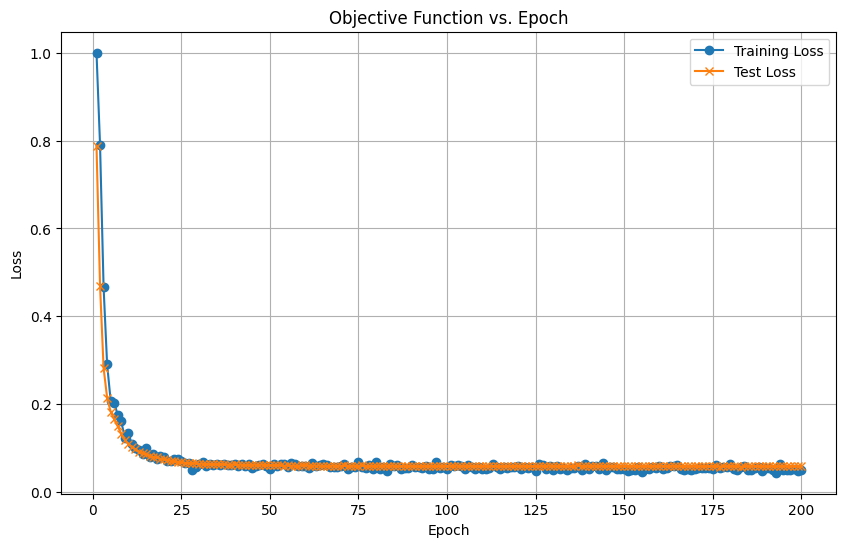

In [20]:
epochs = range(1, len(train_loss) + 1)  # Epochs are 1-based indexing

plt.figure(figsize=(10, 6))
plt.plot(epochs, plot_train_loss, label='Training Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='x')
plt.title('Objective Function vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
os.getcwd()

'/Users/jeqcho/astro-205/grb'

In [22]:
nr = True
dft = False

fname = "final_dft_Autoencoder_"
if nr:
    fname += "Noise_Reduced_"
fname += f"{swift.res}res_"
fname += f'{"".join(str(b) for b in swift.n_bands)}bands_'
if dft:
    fname += f'DFT_'
# notes
fname += f'final-3-latent'


torch.save(AE.state_dict(), f'{fname}state_dict.pth')
# torch.save(AE, f'{fname}.pth')
print(f"Model saved to  f'{fname}state_dict.pth")

Model saved to  f'final_dft_Autoencoder_Noise_Reduced_64res_12345bands_final-3-latentstate_dict.pth


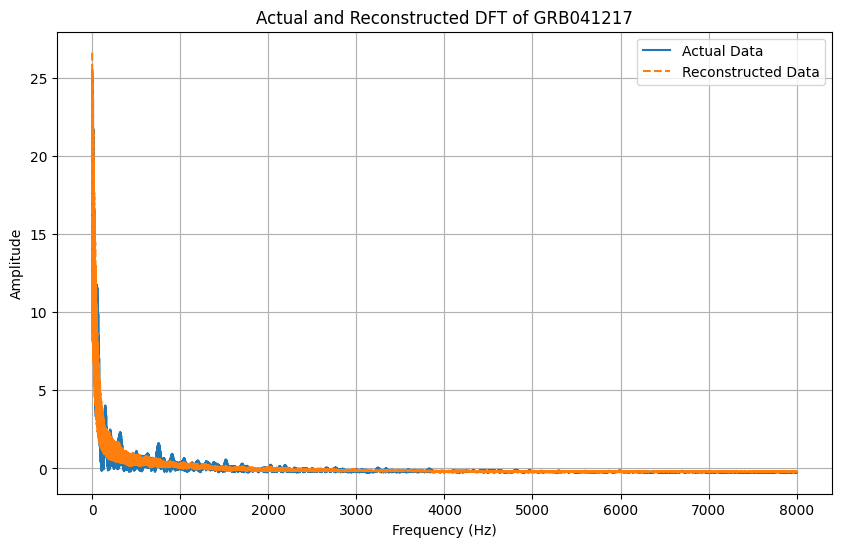

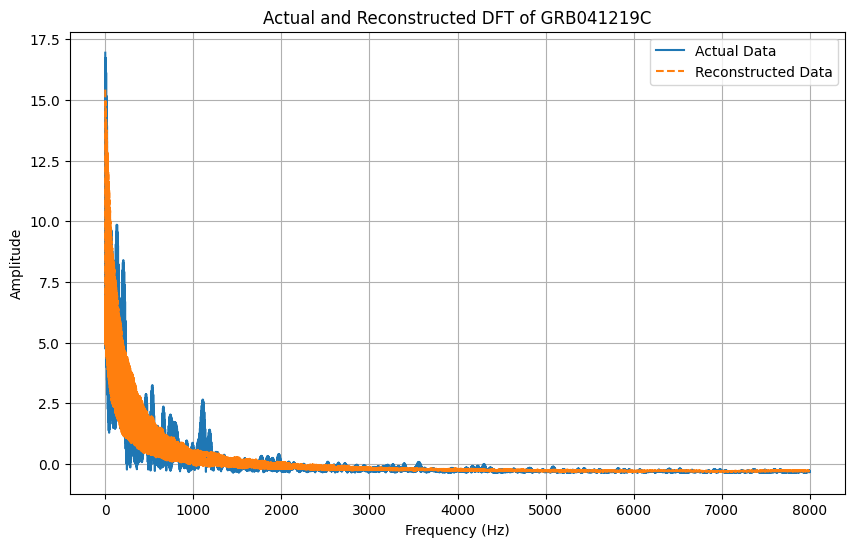

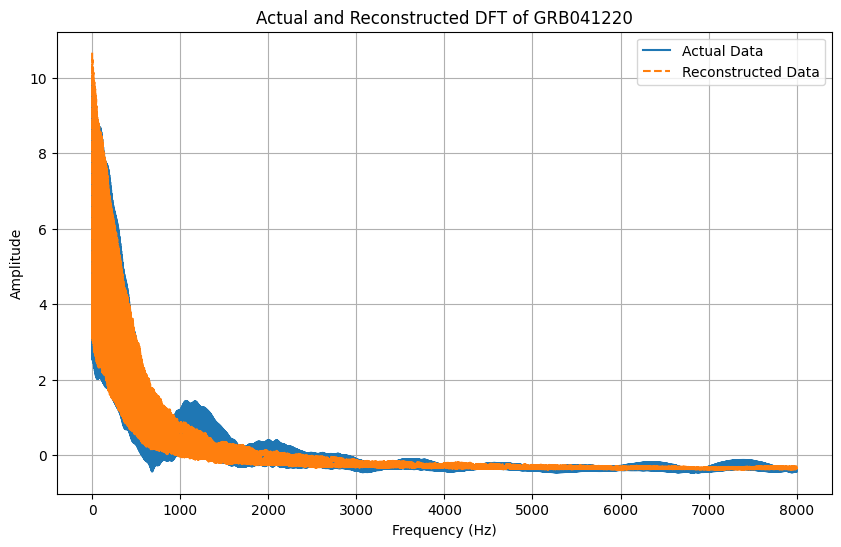

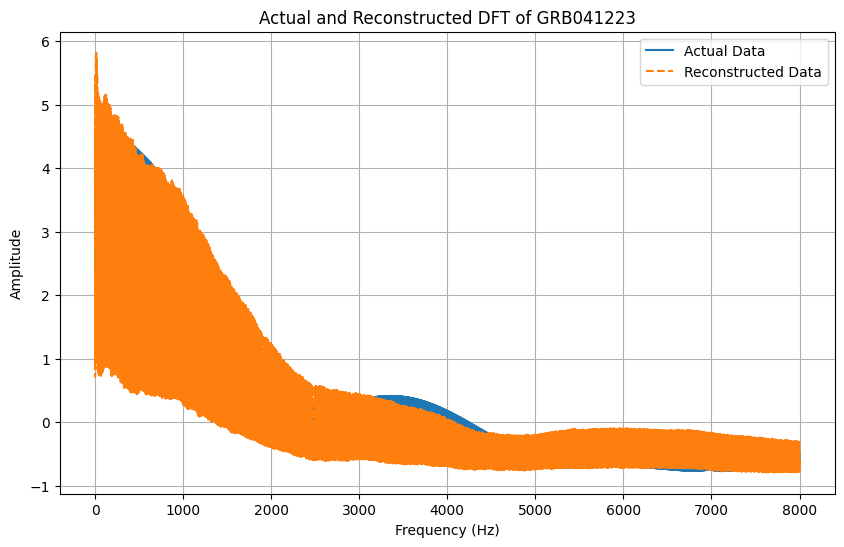

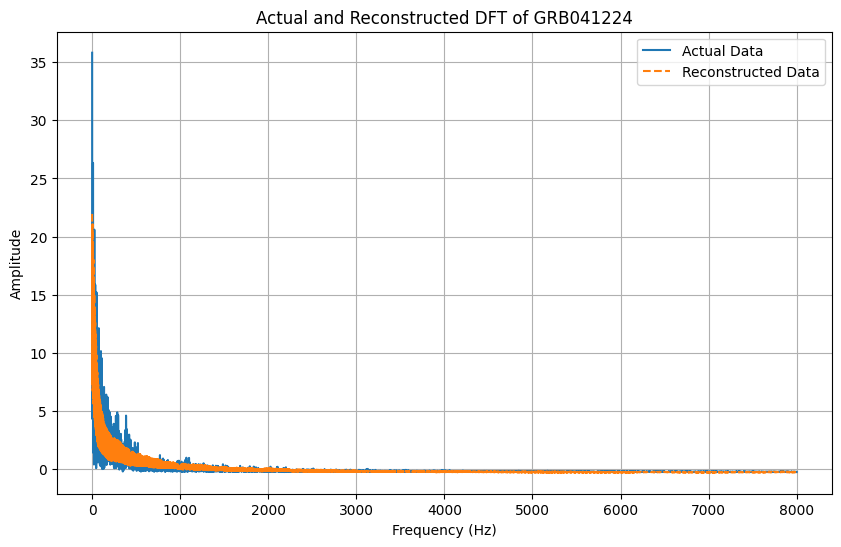

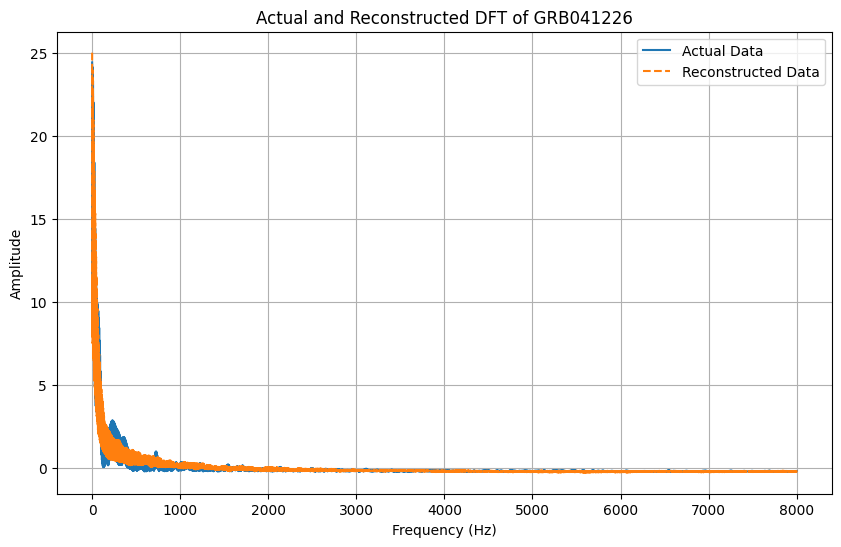

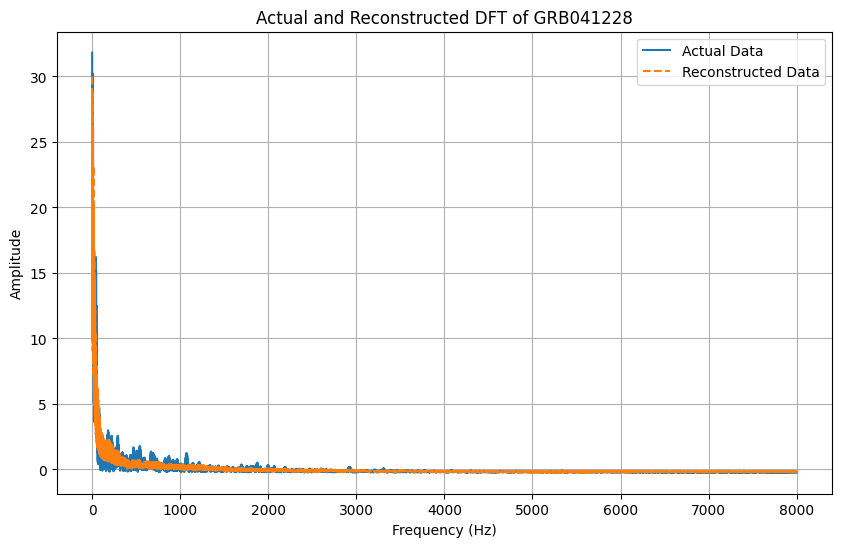

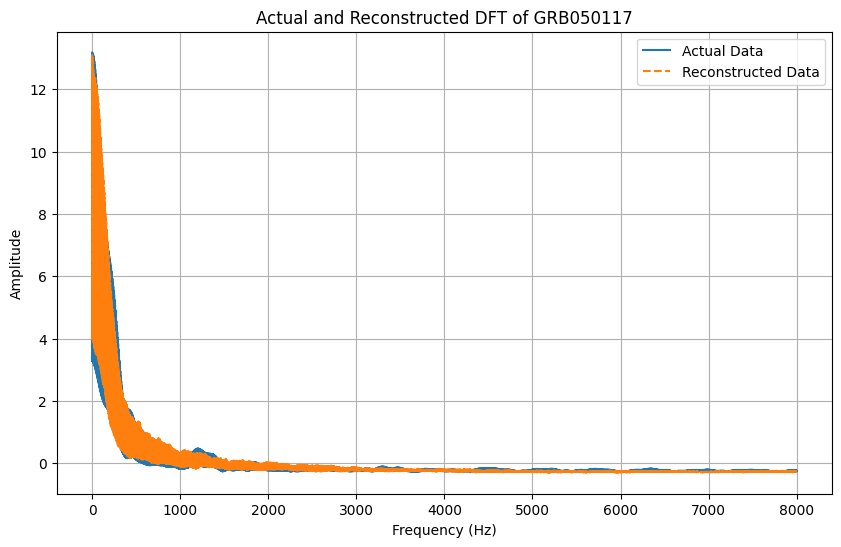

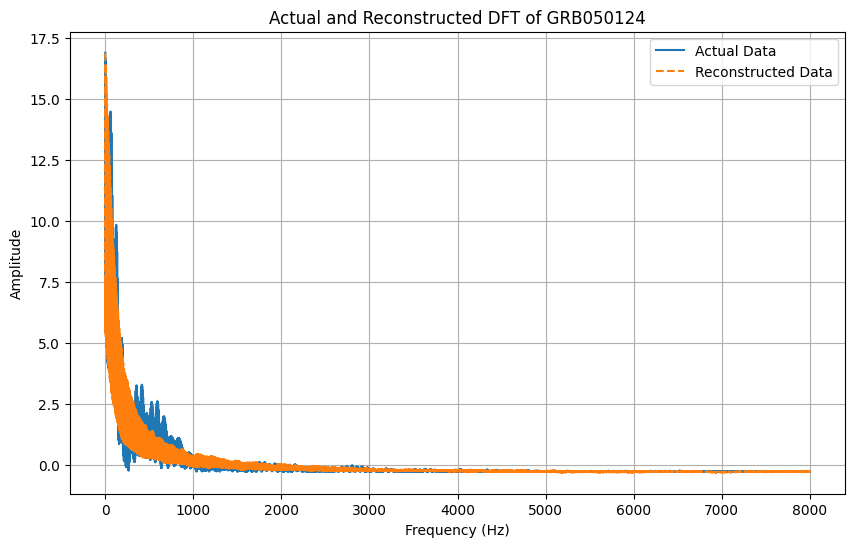

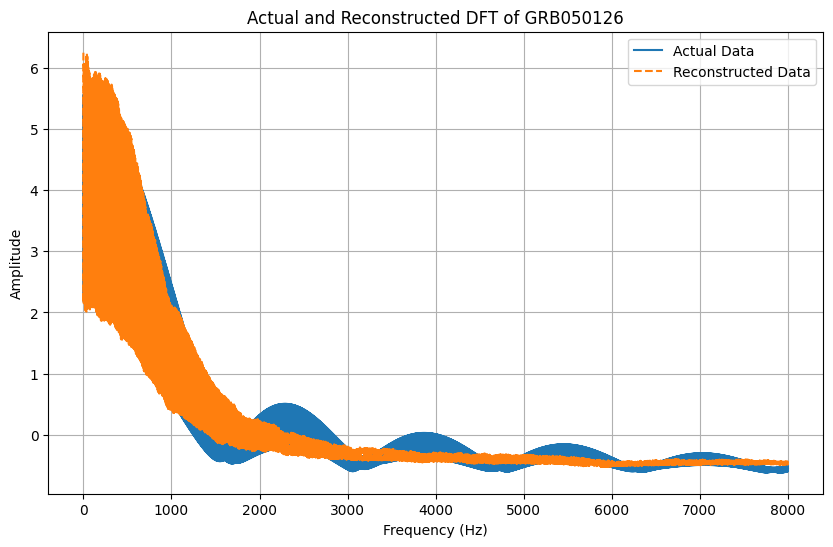

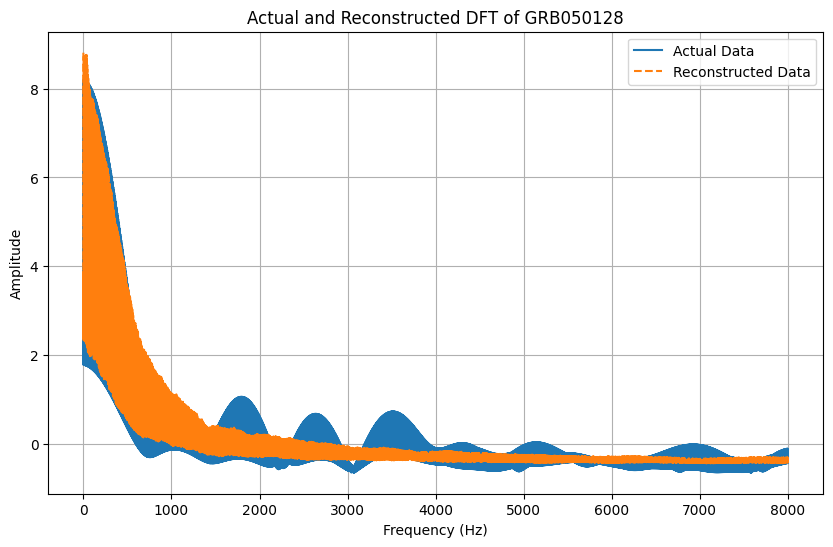

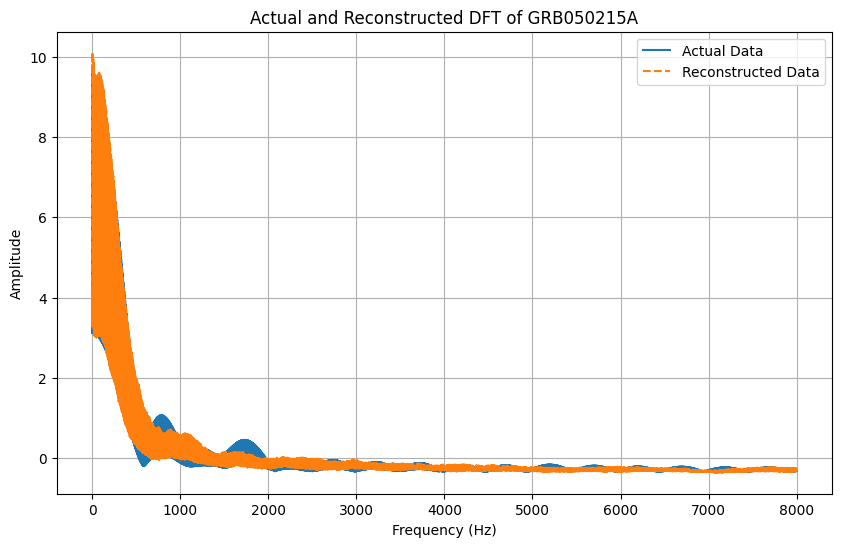

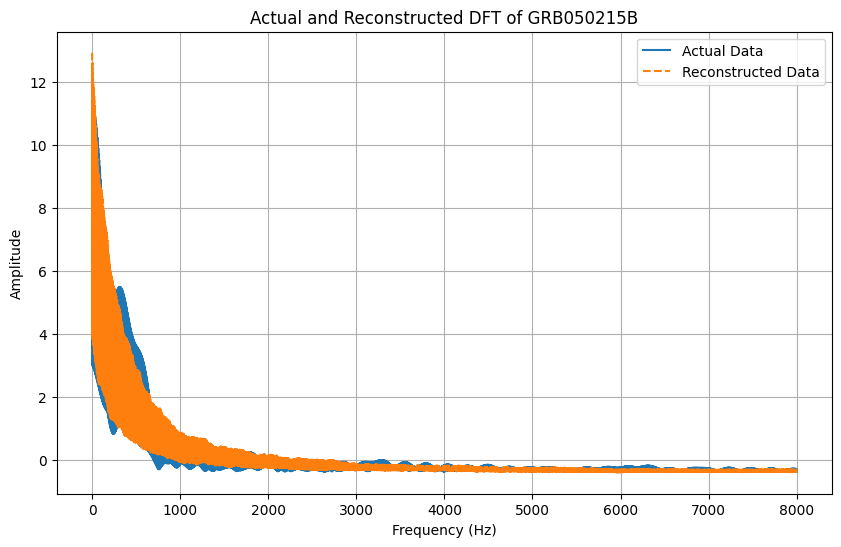

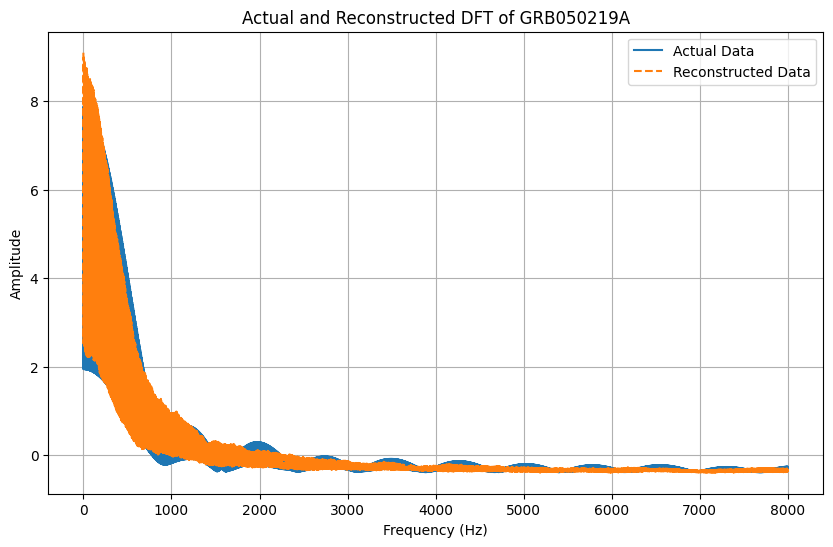

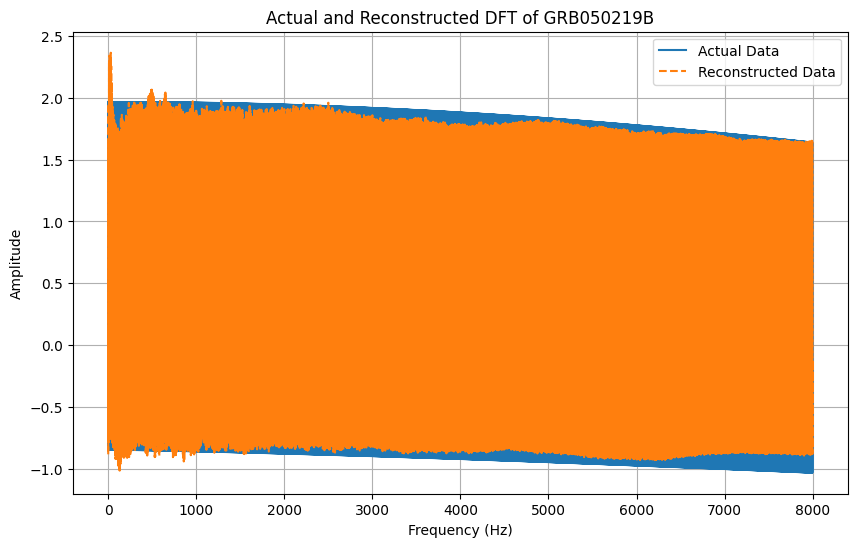

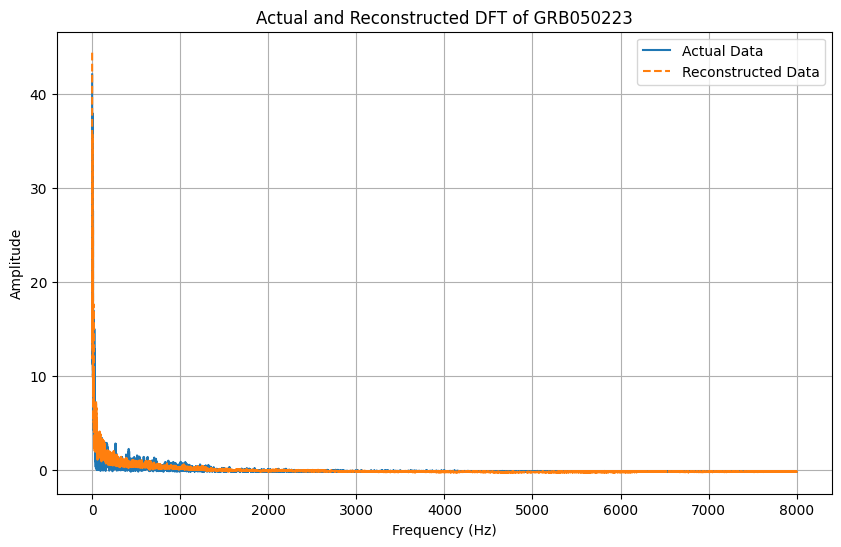

In [23]:
vis_loader = DataLoader(test_dataset, batch_size=16, shuffle=True) # get 16 random spectra

for X_batch, y_batch in vis_loader:
    # Simulated x-axis values for the spectrum
    x = np.linspace(0, features.shape[1], features.shape[1])
    
    with torch.no_grad():
        preds = AE(X_batch).detach()
    
    for i in range(len(X_batch)):
        plt.figure(figsize=(10, 6))
        plt.plot(x, X_batch[i].numpy(), label='Actual Data')  # Converting tensor to numpy array for plotting
        plt.plot(x, preds[i].numpy(), label='Reconstructed Data',linestyle='--')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.title(f'Actual and Reconstructed DFT of {grb_names[i]}')
        plt.legend()
        plt.grid(True)
    break # just need one batch of 16

In [24]:
preds2 = []
for x in normalized_features:
    with torch.no_grad():
        # Convert x from a NumPy array to a PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Add a batch dimension to x
        x_tensor = x_tensor.unsqueeze(0)
        preds2.append(AE.encoder(x_tensor).detach())

preds2 = torch.cat(preds2)
preds2

tensor([[ 75.3565,  24.6507,  59.6383],
        [ 92.7039,  17.1910,  41.3792],
        [ 65.3095,  36.0809,  65.1164],
        ...,
        [ 72.8281,  18.3714,  58.4874],
        [ 79.9081, -20.5018,  51.7552],
        [ 97.8031, -13.0045,  33.2765]])

In [25]:
mask = ~torch.isnan(preds2).any(dim=1)
preds2 = preds2[mask]
torch.sum(~mask)

tensor(0)

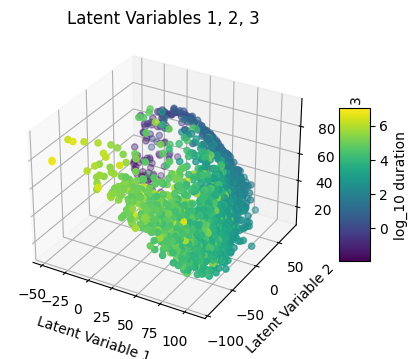

In [26]:
# Get all permutations of three columns out of five (0-based indices)
from itertools import combinations

perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=np.log(durations[mask]), cmap='viridis')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


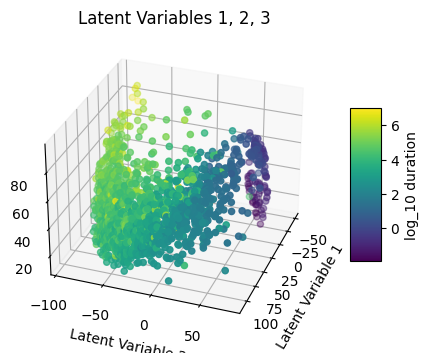

In [68]:
# Get all permutations of three columns out of five (0-based indices)
from itertools import combinations

perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=np.log(durations[mask]), cmap='viridis')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
                ax.view_init(elev=30, azim=20)
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


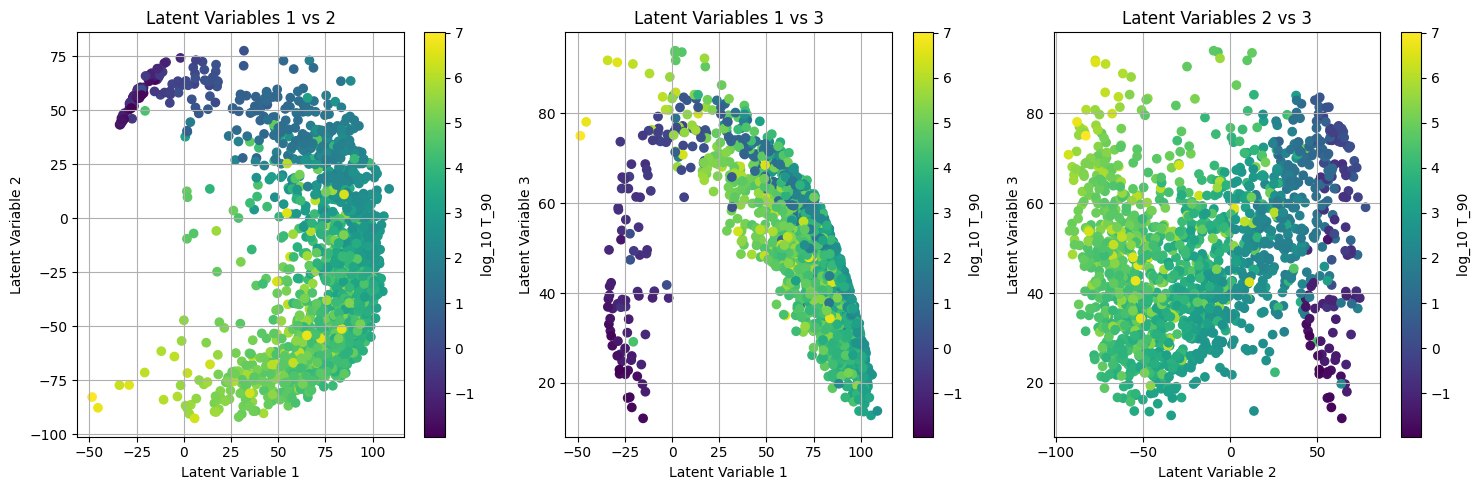

In [54]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
nrows = 1
ncols = 3
figsize = (15,5)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=np.log(durations[mask]), cmap='viridis')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label(label='log_10 T_90')

plt.tight_layout()
plt.show()

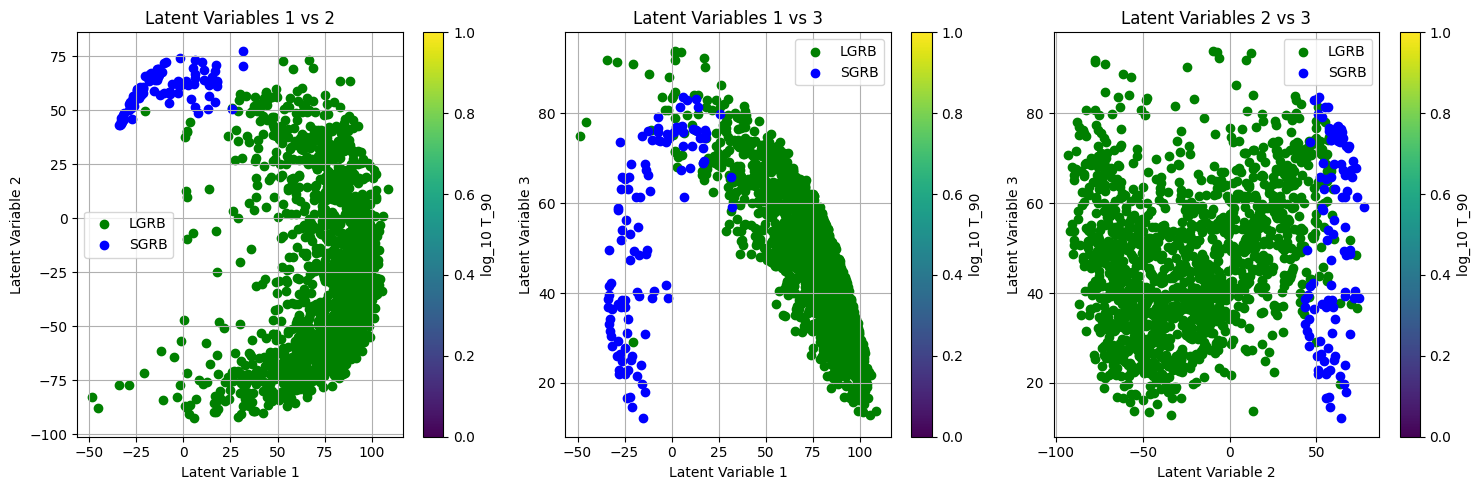

In [56]:
# Generate all combinations of the 5 coordinates taken 2 at a time
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed
highlight_duration = durations[mask] < 2
mask_not_in_highlight = ~highlight_duration
color_min = np.log(durations).min()
color_max = np.log(durations).max()
for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    elif ncols>1:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs
    scatter = ax.scatter(preds2[mask_not_in_highlight, idx1].numpy(), preds2[mask_not_in_highlight, idx2].numpy(),
                         c='green',label="LGRB")
    scatter = ax.scatter(preds2[highlight_duration, idx1].numpy(), preds2[highlight_duration, idx2].numpy(), 
                         c='blue',label="SGRB")
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)
    ax.legend()

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

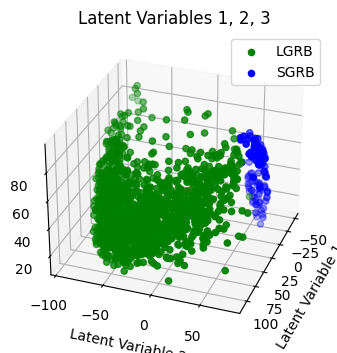

In [77]:
# Get all permutations of three columns out of five (0-based indices)
from itertools import combinations

perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[mask_not_in_highlight, x], preds2[mask_not_in_highlight, y], 
                                     preds2[mask_not_in_highlight, z], c='green',label="LGRB")
                scatter = ax.scatter(preds2[highlight_duration, x], preds2[highlight_duration, y], 
                                     preds2[highlight_duration, z], c='blue',label="SGRB")
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
                ax.legend()
                ax.view_init(elev=30, azim=20)
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


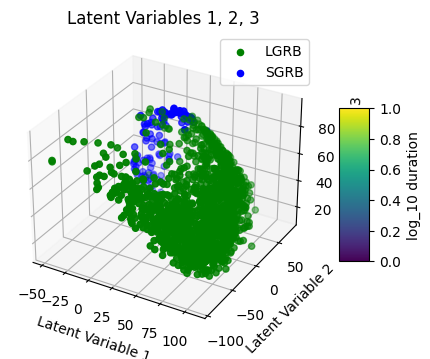

In [69]:
# Get all permutations of three columns out of five (0-based indices)
from itertools import combinations

perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[mask_not_in_highlight, x], preds2[mask_not_in_highlight, y], 
                                     preds2[mask_not_in_highlight, z], c='green',label="LGRB")
                scatter = ax.scatter(preds2[highlight_duration, x], preds2[highlight_duration, y], 
                                     preds2[highlight_duration, z], c='blue',label="SGRB")
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
                ax.legend()
                ax.view_init(elev=30, azim=-60)
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


In [ ]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
nrows = 1
ncols = 3
figsize = (15,5)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=np.log(durations[mask]), cmap='viridis')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label(label='log_10 T_90')

plt.tight_layout()
plt.show()

In [28]:
compact_mergers = [
    "GRB130603B",
    "GRB060614",
    "GRB080503",
    "GRB050709",
    "GRB050724",
    "GRB061006",
    "GRB070714B",
    "GRB160821B",
    "GRB111005A",
    "GRB150101B",
    "GRB070809",
    "GRB211211A",
    "GRB211227A",
    "GRB191019A",
    "GRB230307A"
]
indices = np.where(np.isin(grb_names, compact_mergers))[0]
mask_not_in_indices = ~np.isin(range(len(preds2)), indices)
# Initialize a dictionary to store the results with the merger names as keys
results = {merger: None for merger in compact_mergers}  # Start with None or any placeholder for not found

In [29]:
from sklearn.cluster import KMeans

encoded2 = preds2
kmeans2 = KMeans(n_clusters=2, random_state=205).fit(encoded2)
kmeans2

KMeans(n_clusters=2, random_state=205)

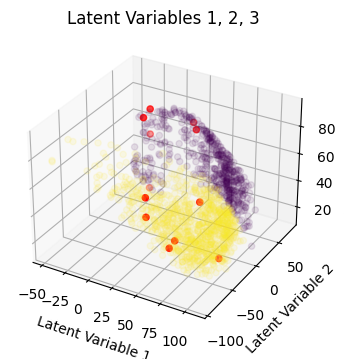

In [30]:
# Get all permutations of three columns out of five (0-based indices)

perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                                     c=kmeans2.labels_[mask_not_in_indices], cmap='viridis',alpha=0.1)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], 
                                     c='r')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

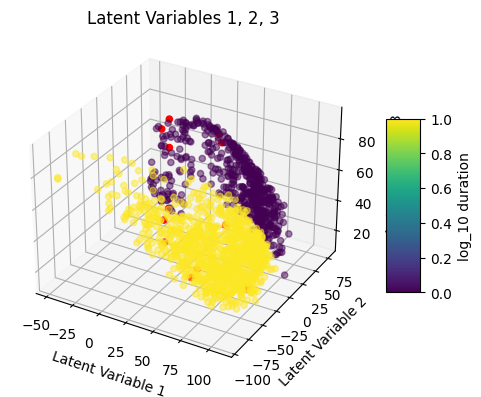

In [71]:
fig = plt.figure(figsize=(6, 4))
x, y, z = [0,1,2]
ax = fig.add_subplot(projection='3d')
# Use durations for coloring
scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                     c=kmeans2.labels_[mask_not_in_indices], cmap='viridis',alpha=0.5)
scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red',alpha=1)
ax.set_xlabel(f'Latent Variable {x+1}')
ax.set_ylabel(f'Latent Variable {y+1}')
ax.set_zlabel(f'Latent Variable {z+1}')
ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
plt.tight_layout()
plt.show()

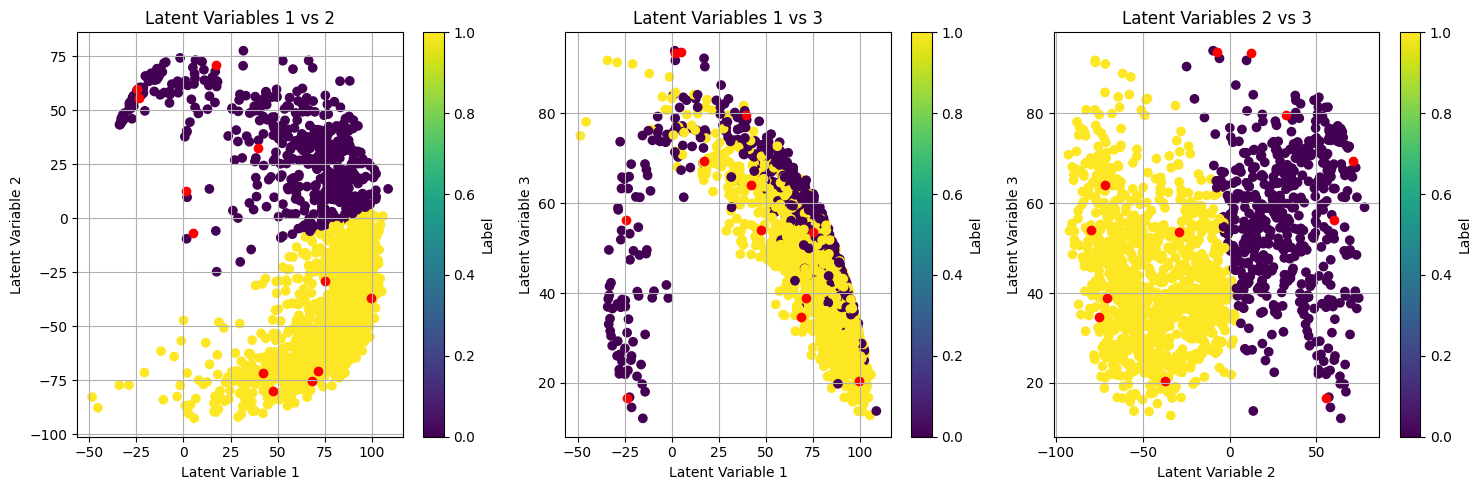

In [32]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[mask_not_in_indices, idx1].numpy(), preds2[mask_not_in_indices, idx2].numpy(), 
                         c=kmeans2.labels_[mask_not_in_indices], cmap='viridis')
    scatter = ax.scatter(preds2[indices, idx1], preds2[indices, idx2], c='red')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [33]:
encoded = preds2

In [34]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_Noise_Reduced_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
names_64ms, features_64ms = data_loaded['names'], data_loaded['data']

In [35]:
names_64ms = names_64ms[mask]

In [36]:
# Values
values = np.array([0, 1])

# Normalize the values to the range of the colormap
normalized_values = values / max(values)

# Get the corresponding colormap
cmap = plt.cm.get_cmap('viridis')

# Apply the colormap to normalized values
colors = cmap(normalized_values)

# Print color values
for value, color in zip(values, colors):
    print(f"Value {value} has color: {color}")

Value 0 has color: [0.267004 0.004874 0.329415 1.      ]
Value 1 has color: [0.993248 0.906157 0.143936 1.      ]


In [37]:
colors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

Finding Durations: 100%|█████████████████████| 547/547 [00:07<00:00, 77.26GRB/s]


Text(0.5, 1.0, 'Frequency Histogram of Duration of GRBs using K=2')

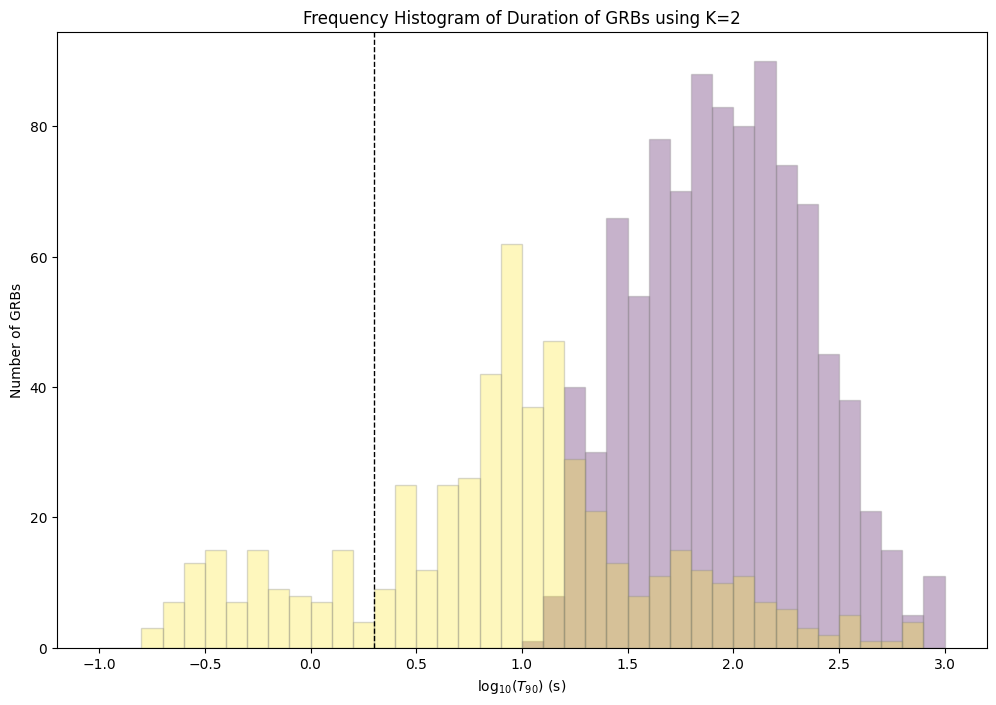

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match = kmeans2.labels_==1
match2 = kmeans2.labels_==0
names1 = names_64ms[match]
names2 = names_64ms[match2]
swift.duration_histogram(names=[names1, names2], alpha=0.3, color_groups=colors, ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')
ax.set_title('Frequency Histogram of Duration of GRBs using K=2')

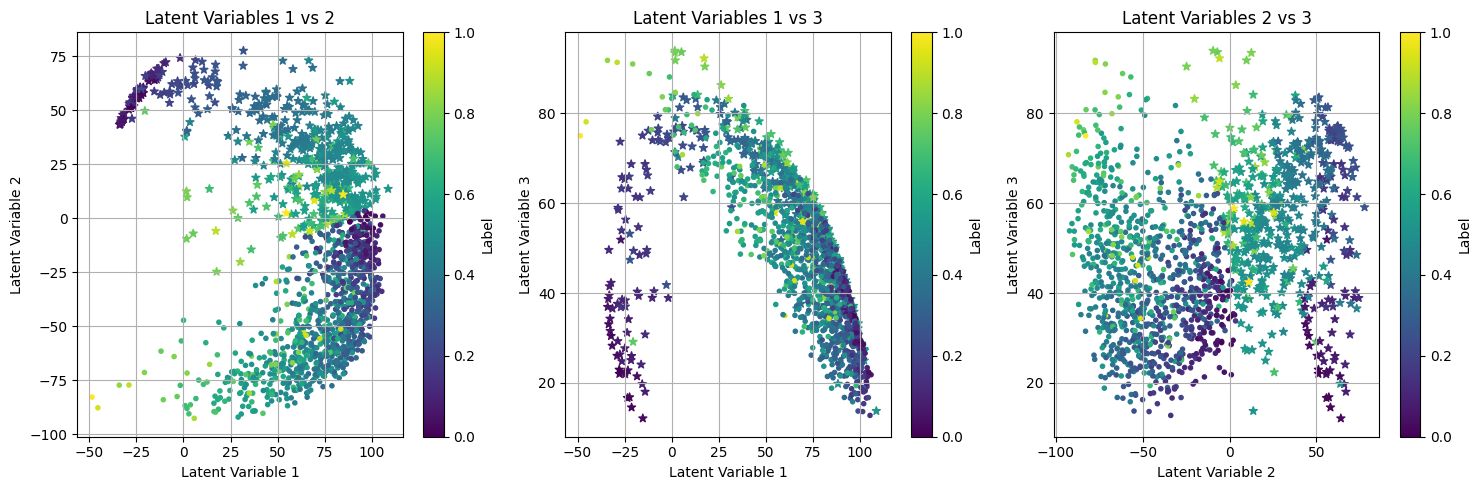

In [39]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

labls = kmeans2.labels_
centers = kmeans2.cluster_centers_
num_class = max(labls)+1
labls_array = np.array([label.item() for label in labls])
description = ['g1','g2']

markers = ['*', '.']
edgecolors = ['red', 'black']

fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    for cluster in range(num_class):
        pred_class_mask = labls == cluster
        ax.scatter(encoded[pred_class_mask,idx1], encoded[pred_class_mask,idx2], 
                   c=np.log(durations[pred_class_mask]), marker=markers[cluster], cmap='viridis')

    # cluster center
    # for idx, center in enumerate(centers):
        # ax.scatter(center[idx1],center[idx2], cmap='viridis', marker='X', s=100, edgecolors='red')

    
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [40]:
import numpy as np


# Exploring the array
print("Shape of the array:", durations[mask].shape)
print("Data type of the array:", durations[mask].dtype)
print("Number of dimensions:", durations[mask].ndim)
print("Total number of elements:", durations[mask].size)

# Describing the durations[mask]
print("Mean of the array:", np.mean(durations[mask]))
print("Standard deviation:", np.std(durations[mask]))
print("Minimum value:", np.min(durations[mask]))
print("Maximum value:", np.max(durations[mask]))
print("25th percentile:", np.percentile(durations[mask], 25))
print("Median:", np.median(durations[mask]))
print("75th percentile:", np.percentile(durations[mask], 75))
print("90th percentile:", np.percentile(durations[mask], 90))
print("95th percentile:", np.percentile(durations[mask], 95))
print("99th percentile:", np.percentile(durations[mask], 99))

Shape of the array: (1513,)
Data type of the array: float64
Number of dimensions: 1
Total number of elements: 1513
Mean of the array: 76.21325842696629
Standard deviation: 107.63104972105164
Minimum value: 0.14
Maximum value: 1104.7520000000002
25th percentile: 11.904
Median: 41.0
75th percentile: 97.69999999999999
90th percentile: 181.992
95th percentile: 270.82320000000004
99th percentile: 545.7420799999968


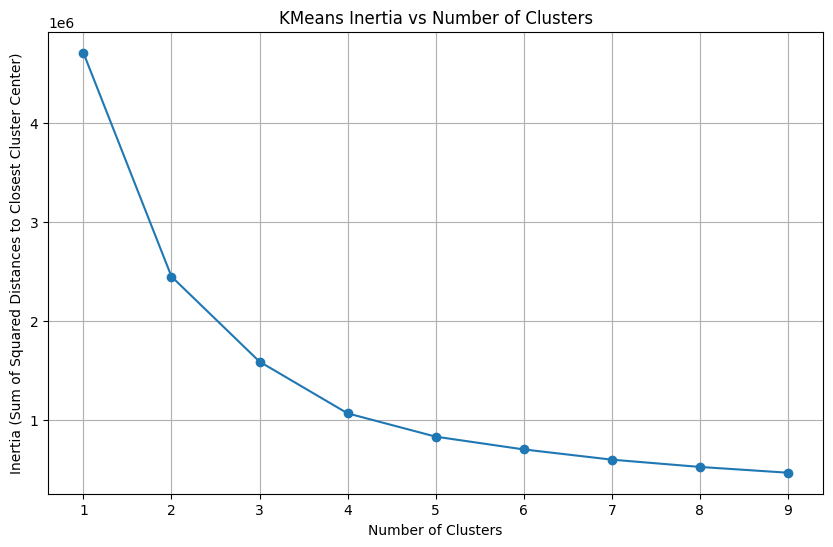

In [41]:
# Try different numbers of clusters
num_clusters = range(1, 10)  # You can adjust the range as needed
inertias = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=205)
    kmeans.fit(encoded2)
    inertias.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, inertias, marker='o')
plt.title('KMeans Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances to Closest Cluster Center)')
plt.grid(True)
plt.show()

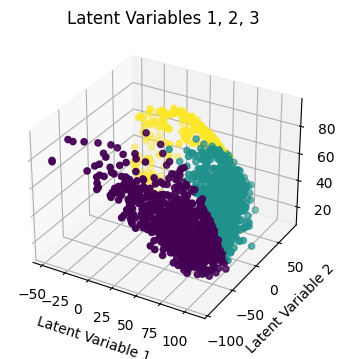

In [42]:
kmeans3 = KMeans(n_clusters=3, random_state=205).fit(encoded2)

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=kmeans3.labels_, cmap='viridis')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

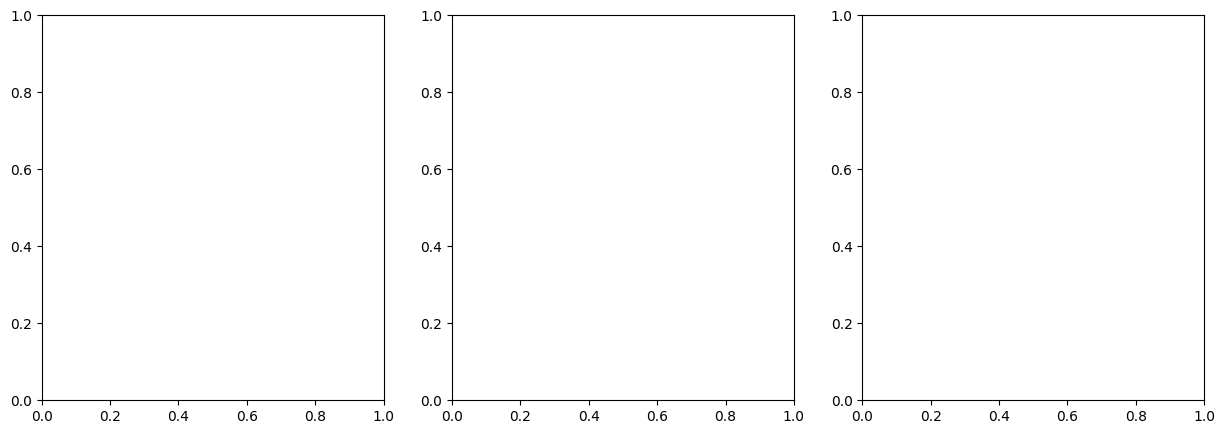

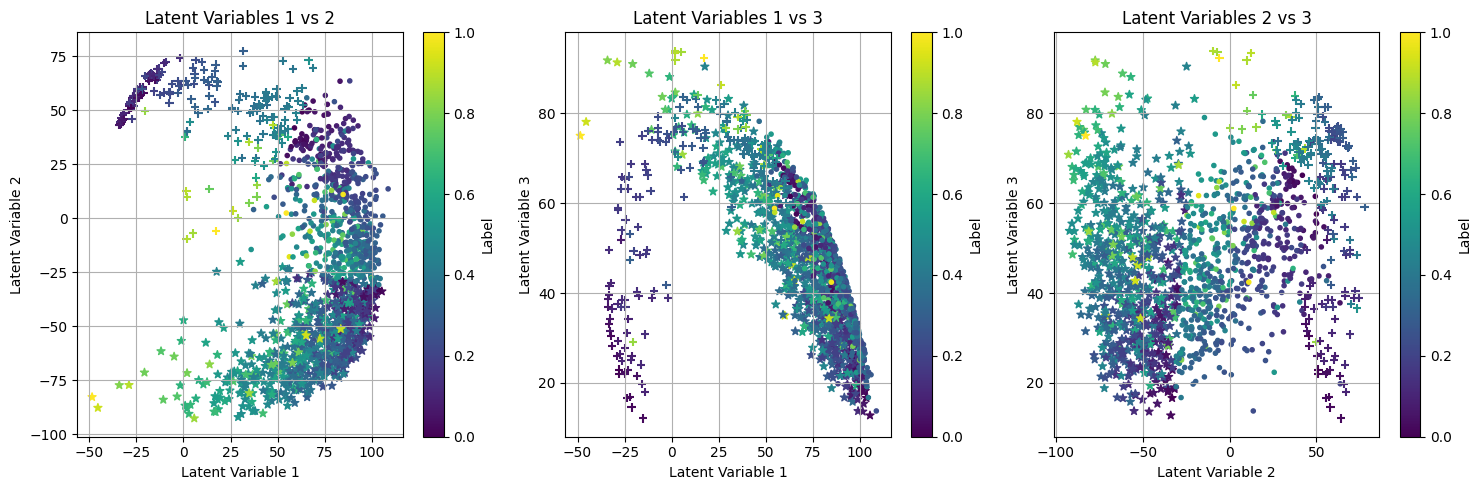

In [43]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

labls = kmeans3.labels_
centers = kmeans3.cluster_centers_
num_class = max(labls)+1
labls_array = np.array([label.item() for label in labls])
description = ['g1','g2','g3']

markers = ['*', '.','+']
edgecolors = ['red', 'black']


fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    for cluster in range(num_class):
        pred_class_mask = labls == cluster
        ax.scatter(encoded[pred_class_mask,idx1], encoded[pred_class_mask,idx2], 
                   c=np.log(durations[pred_class_mask]), marker=markers[cluster], cmap='viridis')

    # cluster center
    # for idx, center in enumerate(centers):
        # ax.scatter(center[idx1],center[idx2], cmap='viridis', marker='X', s=100, edgecolors='red')

    
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

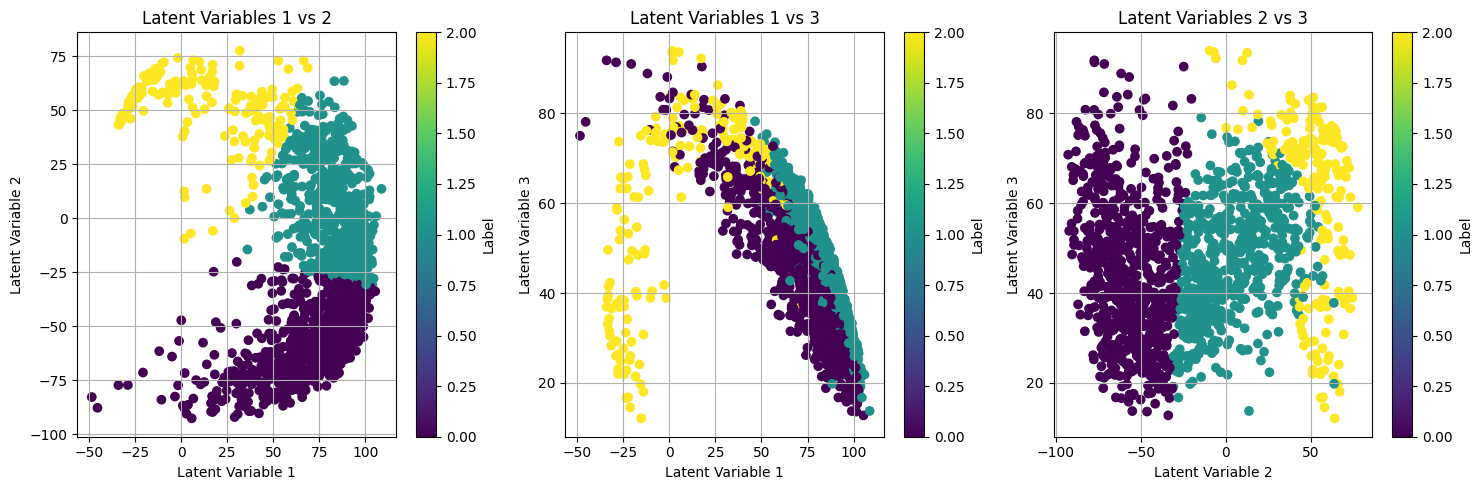

In [76]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=kmeans3.labels_, cmap='viridis')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [45]:
# Values
values = np.arange(3)

# Normalize the values to the range of the colormap
normalized_values = values / max(values)

# Get the corresponding colormap
cmap = plt.cm.get_cmap('viridis')

# Apply the colormap to normalized values
colors = cmap(normalized_values)

# Print color values
for value, color in zip(values, colors):
    print(f"Value {value} has color: {color}")

Value 0 has color: [0.267004 0.004874 0.329415 1.      ]
Value 1 has color: [0.127568 0.566949 0.550556 1.      ]
Value 2 has color: [0.993248 0.906157 0.143936 1.      ]


Finding Durations: 100%|█████████████████████| 202/202 [00:07<00:00, 28.42GRB/s]


Text(0.5, 1.0, 'Frequency Histogram of Duration of GRBs using K=3')

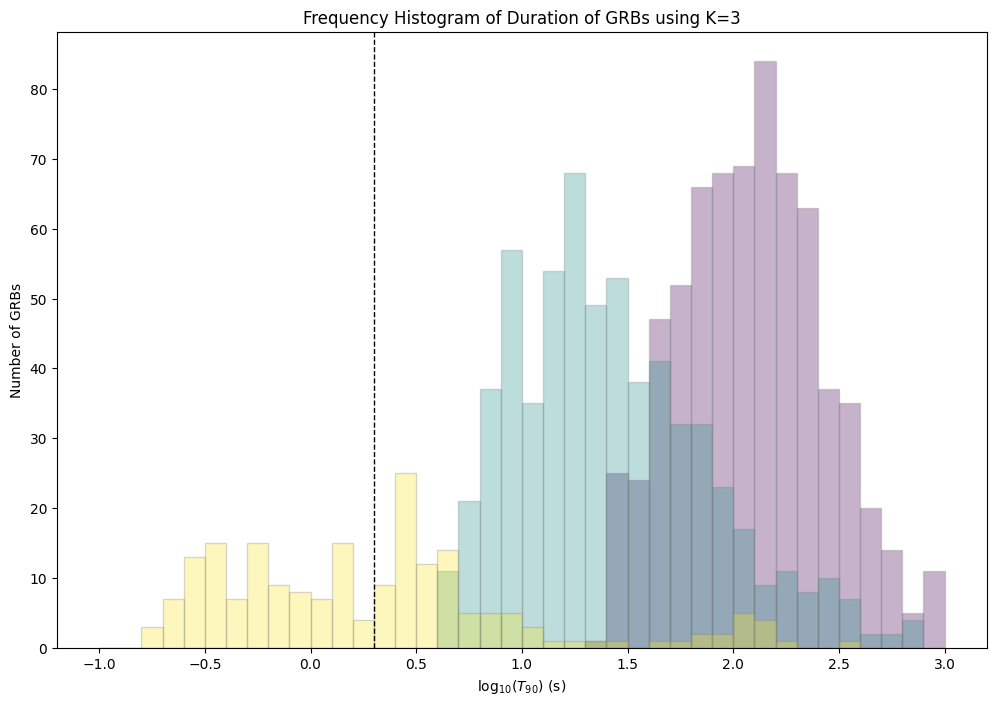

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match1 = kmeans3.labels_==0
match2 = kmeans3.labels_==1
match3 = kmeans3.labels_==2
names1 = names_64ms[match1]
names2 = names_64ms[match2]
names3 = names_64ms[match3]
swift.duration_histogram(names=[names1, names2, names3], alpha=0.3, color_groups=colors, ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')
ax.set_title('Frequency Histogram of Duration of GRBs using K=3')

In [47]:
torch.sum(~mask)

tensor(0)

In [48]:
# Find indices for each item in compact_mergers within names_64ms
for merger in compact_mergers:
    _indices = np.where(names_64ms == merger)[0]
    results[merger] = _indices[0] if _indices.size > 0 else -1  # Store index if found, else store -1

# Printing the results
for key, value in results.items():
    print(f"{key}: {kmeans2.labels_[value]}")

GRB130603B: 0
GRB060614: 1
GRB080503: 1
GRB050709: 1
GRB050724: 0
GRB061006: 0
GRB070714B: 0
GRB160821B: 0
GRB111005A: 1
GRB150101B: 1
GRB070809: 0
GRB211211A: 1
GRB211227A: 1
GRB191019A: 1
GRB230307A: 1


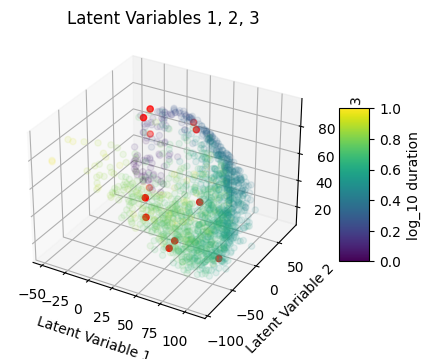

In [49]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], c=np.log(durations[mask_not_in_indices]), cmap='viridis',alpha=0.1)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


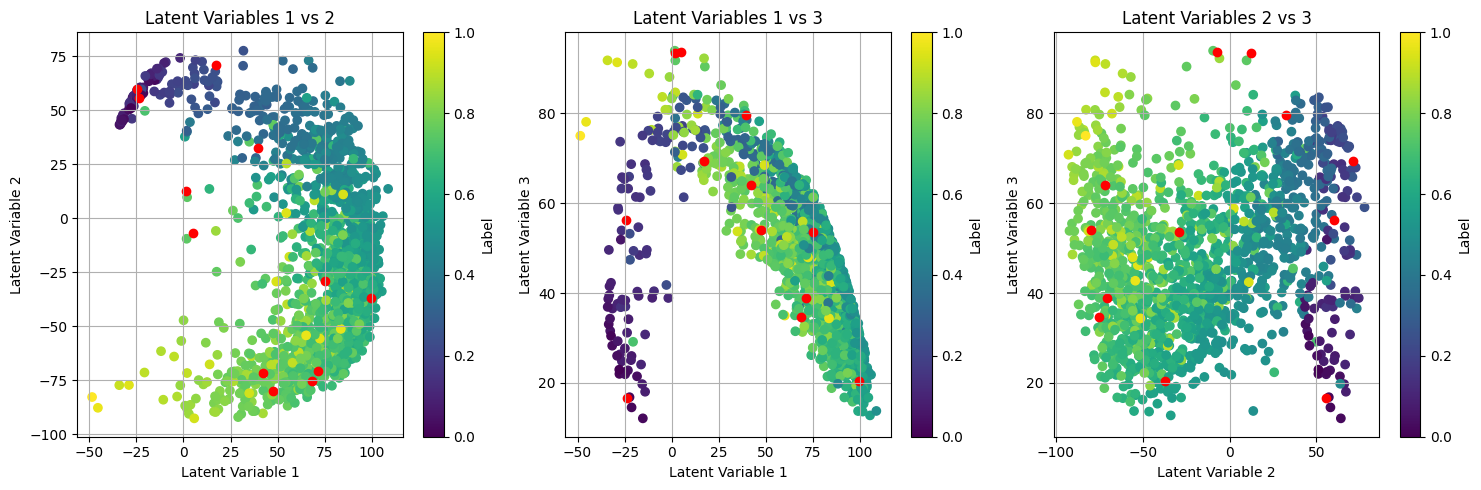

In [50]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))


fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[mask_not_in_indices, idx1].numpy(), preds2[mask_not_in_indices, idx2].numpy(), c=np.log(durations[mask_not_in_indices]), cmap='viridis')
    scatter = ax.scatter(preds2[indices, idx1], preds2[indices, idx2], c='red')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

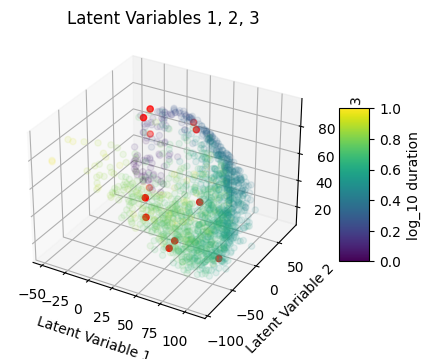

In [51]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], c=np.log(durations[mask_not_in_indices]), cmap='viridis',alpha=0.1)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


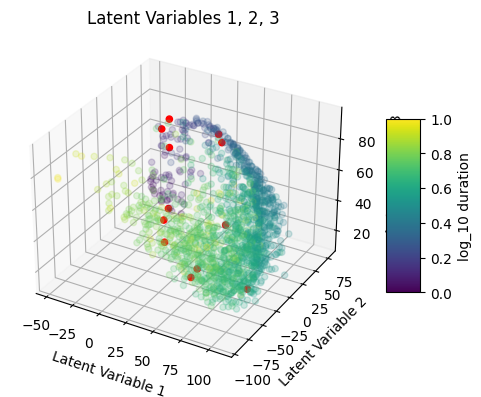

In [52]:
fig = plt.figure(figsize=(6, 4))
x, y, z = [0,1,2]
ax = fig.add_subplot(projection='3d')
# Use durations for coloring
scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                     c=np.log(durations[mask_not_in_indices]), cmap='viridis',alpha=0.2)
scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red',alpha=1)
ax.set_xlabel(f'Latent Variable {x+1}')
ax.set_ylabel(f'Latent Variable {y+1}')
ax.set_zlabel(f'Latent Variable {z+1}')
ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
plt.tight_layout()
plt.show()

IndexError: index 3 is out of bounds for dimension 1 with size 3

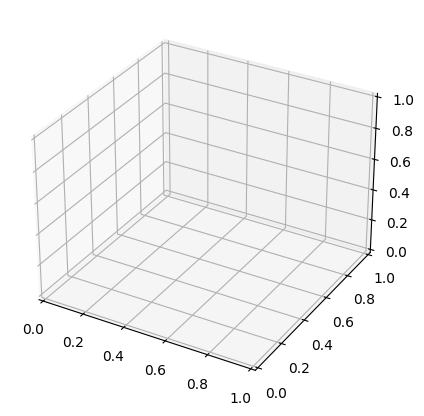

In [53]:
# Define the viewing angles
viewing_angles = [
    (30, 45),
    (60, 120),
    (90, 210)
]
x, y, z = [1,2,3]
# Loop over each angle pair and create a separate plot
for i, (elev, azim) in enumerate(viewing_angles, start=1):
    # Square figsize for clear 3D plots
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')

    # Use durations for coloring
    scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                         c=np.log(durations[mask_not_in_indices]), cmap='viridis', alpha=0.5)
    # Highlighted points
    scatter_highlight = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red', alpha=1)

    # Set labels and title
    ax.set_xlabel(f'Latent Variable {x+1}', fontsize=10)
    ax.set_ylabel(f'Latent Variable {y+1}', fontsize=10)
    ax.set_zlabel(f'Latent Variable {z+1}', fontsize=10)
    ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}', fontsize=12)

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Add a colorbar with label
    colorbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')
    colorbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

    # If you want to save the figure
    # plt.savefig(f'3d_plot_view_{i}.png', bbox_inches='tight')


In [ ]:
# Define the viewing angles
viewing_angles = [
    (30, 45),
    (60, 120),
    (90, 210)
]
x, y, z = [0,1,2]
# Loop over each angle pair and create a separate plot
for i, (elev, azim) in enumerate(viewing_angles, start=1):
    # Square figsize for clear 3D plots
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')

    # Use durations for coloring
    scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                         c=np.log(durations[mask_not_in_indices]), cmap='viridis', alpha=0.5)
    # Highlighted points
    scatter_highlight = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red', alpha=1)

    # Set labels and title
    ax.set_xlabel(f'Latent Variable {x+1}', fontsize=10)
    ax.set_ylabel(f'Latent Variable {y+1}', fontsize=10)
    ax.set_zlabel(f'Latent Variable {z+1}', fontsize=10)
    ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}', fontsize=12)

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Add a colorbar with label
    colorbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')
    colorbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

    # If you want to save the figure
    # plt.savefig(f'3d_plot_view_{i}.png', bbox_inches='tight')
